In [2]:
!pip install simpleitk
!pip install numpy
!pip install pynrrd
!pip install opencv-python

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os as os
import nrrd as reader
import tensorflow as tf
#from sklearn.preprocessing import Normalizer
import cv2  
from skimage import morphology
from skimage.measure import label
from skimage.segmentation import active_contour
from skimage import data, io, img_as_ubyte,filters

j = 5

# Image Import

In [4]:
def join(one, two):
    return os.path.join(one, two)

In [5]:
def check_path(path):
    count=0
    for files in sorted(os.listdir(path)):
        image_path = os.path.join(path,files)
        count+=1
    return count

In [6]:
# (patient count* 15) check_path function will return total patient count 
folder_path = join(os.getcwd(), "Incoming Annotations")
length = check_path(folder_path)
inputs = np.zeros((length*15,256,256, 1))
outputs = np.zeros((length*15,256,256 , 9))

In [7]:
# #functions for inhomogeneity correction 
def correct_roi(image):
    inputImage=sitk.GetImageFromArray(image)
    inputImage = sitk.Cast(inputImage, sitk.sitkFloat32 )
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    output = corrector.Execute( inputImage)
    image_c= sitk.GetArrayFromImage(output)
    image_c=cv2.normalize(src=image_c, dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) #need to normalize, not direct conversion by "np.uint8"
    return image_c

In [8]:
def dcm_to_np(path):
    global dic_count
    try:
        slice_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(path)
        image = sitk.ReadImage(slice_filenames)
        for x in range(15):
            current_slice = image[:, :, x] #************************
            current_array = sitk.GetArrayFromImage(current_slice)
           # Ivol=sitk.GetArrayFromImage(inputs[:, :, :])
            split_array = current_array[:,:-256]
            inputs[dic_count] = split_array[:, :, np.newaxis]
            dic_count+=1
        print(dic_count)
    except Exception as e:
        print(e)
#         print("Problem with this folder -> " + path)

In [9]:
def nrrd_to_np(meta_object):
    global ann_count
    try:
        data = sitk.GetArrayFromImage(meta_object)
        for p in range(15):
            current_seg = data[p, :, :]
            half_seg= current_seg[:,:-256]
            black = np.zeros([256, 256, 9])
            for y, a in enumerate(half_seg):
                for x, b in enumerate(a):
                    if b>0:
                        black[y][x][b-1] = 1
            outputs[ann_count] = black
            ann_count+=1
        print(ann_count)
    except Exception as e:
        print(e)

In [10]:
dic_count = 0
ann_count = 0
try:
    for patient in sorted(os.listdir(folder_path)):
            patient_path = join(folder_path, patient)
            nrrd_folder = join(patient_path, "NRRD")
            dcm_to_np(patient_path)
            for nrrd in os.listdir(nrrd_folder):
                if(".nrrd" in nrrd):
                    segmentation = sitk.ReadImage(join(nrrd_folder, nrrd))
                    nrrd_to_np(segmentation)
                    if(".DS_Store" in nrrd):
                        pass
except Exception as e:
    print(e)


Exception thrown in SimpleITK ImageSeriesReader_Execute: /Users/runner/work/1/sitk/Code/IO/src/sitkImageSeriesReader.cxx:129:
sitk::ERROR: File names information is empty. Cannot read series.
[Errno 20] Not a directory: '/Users/jasontsang/Desktop/[TBD] RAMER/Incoming Annotations/.DS_Store/NRRD'


In [11]:
#opencv + numpy normalization 
for x in range (j):    
    temp = inputs[x].reshape(256, 256)
    temp1= correct_roi(temp)
    np.linalg.norm(temp1)
    inputs[x]=temp1[:, :, np.newaxis]
    print(x)

0
1
2
3
4


In [12]:
temp = inputs[1].reshape(256,256)
temp.max()


0.0

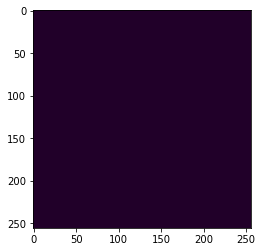

In [13]:
for i in range(1):
    plt.imshow(inputs[i].reshape(256, 256), cmap=plt.cm.bone)
    plt.imshow(outputs[i][:, :, 2], alpha=0.5)
    plt.show()

In [14]:
#Merging all 9 channels of masks into 1 channel
merged_array = np.zeros((1755, 256, 256, 1))
for x in range (j):
    for i in range (9):
        if i !=2:
        merged_array[x,:,:,0]+=outputs[x,:,:, i]
            
merged_array1=merged_array[:, :, :, 0]
inputs1=inputs[:, :, :, 0]


IndentationError: expected an indented block (<ipython-input-14-a6c13154af36>, line 6)

In [47]:
invarray = np.zeros((1755, 256, 256, 1))
for x in range (j):
    for i in range (9):
        invarray[x,:,:,0]+=outputs[x,:,:,i]
        
invpreroi=invarray[:, :, :, 0]

# Image Processing

In [ ]:
for i in range (1):
    plt.imshow(inputs1[i].reshape(256, 256), cmap=plt.cm.bone)
    plt.imshow(outputs[i][:, :, 7], alpha=0.5)
    plt.show()
    

In [ ]:
for i in range (1,2):
    plt.imshow(merged_array1[i],cmap=plt.cm.bone)
    plt.show()

In [ ]:
#Show the Alignment of merged_array (yellow)
for i in range(1):   
    plt.imshow(inputs[i].reshape(256, 256), cmap=plt.cm.bone)
    plt.imshow(merged_array[i][:, :],cmap=plt.cm.bone, alpha=0.5)
    plt.show()

In [ ]:
#Removal of Background Noise
thigh=merged_array1*inputs1
for i in range (1):
    plt.imshow(roi[i], cmap=plt.cm.bone)
    plt.show()


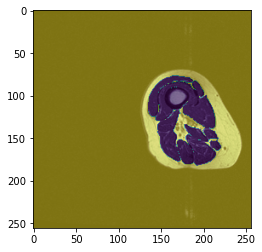

In [49]:
#Only Subcut Fat
invmask=1-invpreroi
    
#Visual Confirmation of the inverse masks and the original DCM
for i in range(1):   
    plt.imshow(inputs1[i], cmap=plt.cm.bone)
    plt.imshow(invmask[i], alpha=0.5)
    plt.show()

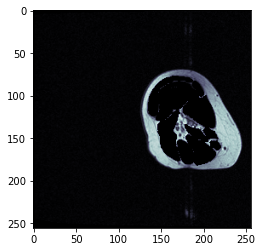

In [50]:
invroi=invmask*inputs1
for i in range (1):
    plt.imshow(invroi[i],cmap=plt.cm.bone)
    plt.show()

In [26]:
##Initial Threshold Seeking via Multi OTSU
def multi_otsu(image):
    motsuth=filters.threshold_multiotsu(image, classes=3)
    print(motsuth)
    print (f"Slice {i+1} otsu threshold={motsuth[1]}")
    regions=np.digitize(image,bins=motsuth)
    output=img_as_ubyte(regions)
    fig, ax=plt.subplots (1,4, figsize=(10,5))
    ax[0].imshow(image, cmap="bone")
    ax[0].set_title(f"Slice {i+1} Original")
    ax[0].axis("off")
    ax[1].hist(image.ravel(),256,[20,256])
    #ax[1].hist(image.ravel(),bins=255)
    for th in motsuth:
            ax[1].axvline(th,color="r")
    ax[2].imshow(regions,cmap="Accent")
    ax[2].set_title("Multi-Otsu Result")
    ax[2].axis ("off")
    ax[3].imshow(image>motsuth[1],cmap="bone")
    ax[3].set_title("Threshold Applied")
    ax[3].axis ("off")
    return motsuth[1] #(fat+ muscle th)

# # ITSA Implementation (Merged Mask)

[31.40039062 86.91992188]
Slice 1 otsu threshold=86.919921875


/Users/jasontsang/opt/anaconda3/lib/python3.8/site-packages/skimage/util/dtype.py:525: UserWarning: Downcasting int64 to uint8 without scaling because max value 2 fits in uint8
  return _convert(image, np.uint8, force_copy)


[24.73242188 79.69335938]
Slice 2 otsu threshold=79.693359375
[28.81835938 82.90820312]
Slice 3 otsu threshold=82.908203125
[31.0078125 92.0390625]
Slice 4 otsu threshold=92.0390625
[31.01367188 98.59570312]
Slice 5 otsu threshold=98.595703125


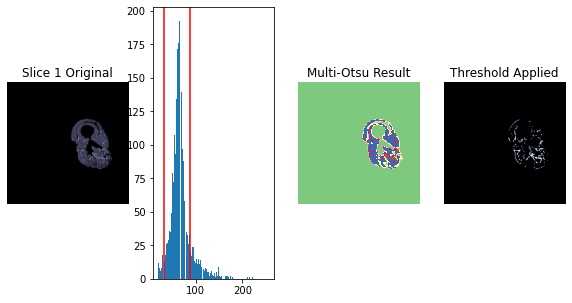

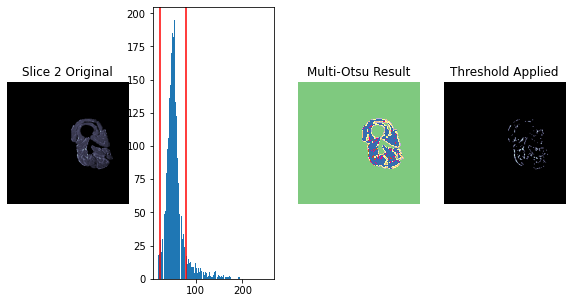

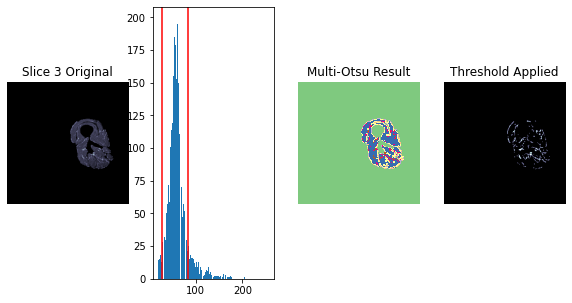

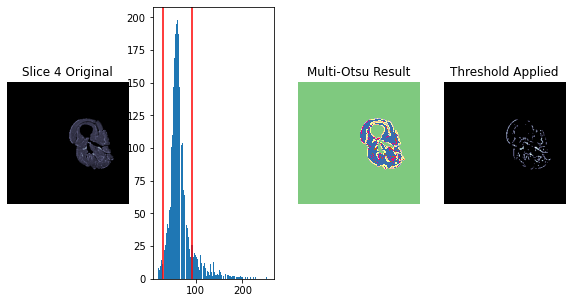

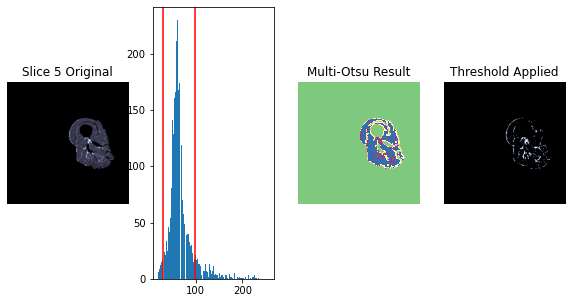

In [27]:
iThreshold=[]
for i in range(j):
    iThreshold.append([])
    iThreshold[i]=multi_otsu(roi[i])

In [28]:
def ITSA(i, roivar, ots, zcheck):
    k=1
    ThPrev=0 
    ThRev= ots[i] 
    x=0
    y=0
    while ThRev!=ThPrev:
        ThPrev=ThRev
        prefatmask = (roivar[i]>ThRev)
        prefatmask = np.uint8(prefatmask)
        ret, fatmask = cv2.threshold(prefatmask,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next=zcheck[i+1]+fatmask
            ret, fatconnectedparts_next= cv2.threshold(fatcombined_next,1,1,cv2.THRESH_BINARY)
            z_connection=fatconnectedparts_next
        elif i==(j-1):
            fatcombined_prev=zcheck[i-1]+fatmask
            ret, fatconnectedparts_prev= cv2.threshold(fatcombined_prev,1,1,cv2.THRESH_BINARY)
            z_connection=fatconnectedparts_prev  
        else:
            fatcombined_prev=zcheck[i-1]+fatmask
            fatcombined_next=fatmask+zcheck[i+1]
            ret, fatconnectedparts_prev= cv2.threshold(fatcombined_prev,1,1,cv2.THRESH_BINARY)
            ret, fatconnectedparts_next= cv2.threshold(fatcombined_next,1,1,cv2.THRESH_BINARY)

            z_connection=fatconnectedparts_prev+fatconnectedparts_next
            ret, z_connection= cv2.threshold(z_connection,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates= np.argwhere(z_connection ==1) #put coordinates of Z-connections into a list      
        im_ff=fatmask.copy()
        h, w = im_ff.shape[:2] #added
        mask = np.zeros((h+2, w+2), np.uint8)
        for item in range(len(coordinates)):
            cv2.floodFill(im_ff, mask, (coordinates[item][1],coordinates[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ =label(im_ff==1)
        nonZ_keep = (morphology.remove_small_objects(nonZ,min_size=8, connectivity=1))
        ret, nonZ_keep= cv2.threshold(np.uint8(nonZ_keep),0,1,cv2.THRESH_BINARY)
        Z = (im_ff==2)
        prefatseg1=(Z+nonZ_keep) #do we need int cus boolean??
        fatseg1=prefatseg1*roivar[i]
        #Fat and Muscle Quantification
        preMuscSegP=roivar[i]-fatseg1
        MuscSegP=np.ma.masked_where(preMuscSegP == 0, preMuscSegP)
        FatSegP=np.ma.masked_where(fatseg1==0,fatseg1) 
        MuscSegI=np.mean(MuscSegP)
        FatSegI=np.mean(FatSegP)
        ThRev=(1+((FatSegI-MuscSegI)/FatSegI))*MuscSegI
        print (f"Slice #{i+1} Iteration={k}\n\tThPrev={ThPrev}\n\tThRev={ThRev}\n")

        k+=1
        if k==50:
            break

    thresholds=ThRev
    return prefatseg1, fatseg1, thresholds

In [29]:
#Original + Original Revised
#Th1 R2
fatseg1vol_mask=np.zeros([inputs1.shape[0], inputs1.shape[1], inputs1.shape[2]], dtype='uint8')
fatseg1vol=np.zeros([inputs1.shape[0], inputs1.shape[1], inputs1.shape[2]], dtype='uint8') #change name
threshold_R1=[] #change name compared to single slice?
for i in range(j):
    threshold_R1.append([])
    fatseg1vol_mask[i],fatseg1vol[i], threshold_R1[i]=ITSA(i, thigh,iThreshold,merged_array1)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Th1 = {threshold_R1[i]}")
    print ("-----------------------------------------------------------")

for i in range(j):
    print (f"Slice #{i+1} Th1 OG/Rev={threshold_R1[i]}")

Slice #1 Iteration=1
	ThPrev=86.919921875
	ThRev=87.93793021981233

Slice #1 Iteration=2
	ThPrev=87.93793021981233
	ThRev=88.55661759527247

Slice #1 Iteration=3
	ThPrev=88.55661759527247
	ThRev=88.75739709741808

Slice #1 Iteration=4
	ThPrev=88.75739709741808
	ThRev=88.75739709741808

Slice #1 Th1 = 88.75739709741808
-----------------------------------------------------------
Slice #2 Iteration=1
	ThPrev=79.693359375
	ThRev=76.45310926746235

Slice #2 Iteration=2
	ThPrev=76.45310926746235
	ThRev=75.30810884897097

Slice #2 Iteration=3
	ThPrev=75.30810884897097
	ThRev=74.87077786557728

Slice #2 Iteration=4
	ThPrev=74.87077786557728
	ThRev=74.34899293326318

Slice #2 Iteration=5
	ThPrev=74.34899293326318
	ThRev=74.34899293326318

Slice #2 Th1 = 74.34899293326318
-----------------------------------------------------------
Slice #3 Iteration=1
	ThPrev=82.908203125
	ThRev=81.79725548594928

Slice #3 Iteration=2
	ThPrev=81.79725548594928
	ThRev=81.44055154872362

Slice #3 Iteration=3
	ThPr

<ipython-input-28-c817768aa30e>:37: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nonZ_keep = (morphology.remove_small_objects(nonZ,min_size=8, connectivity=1))


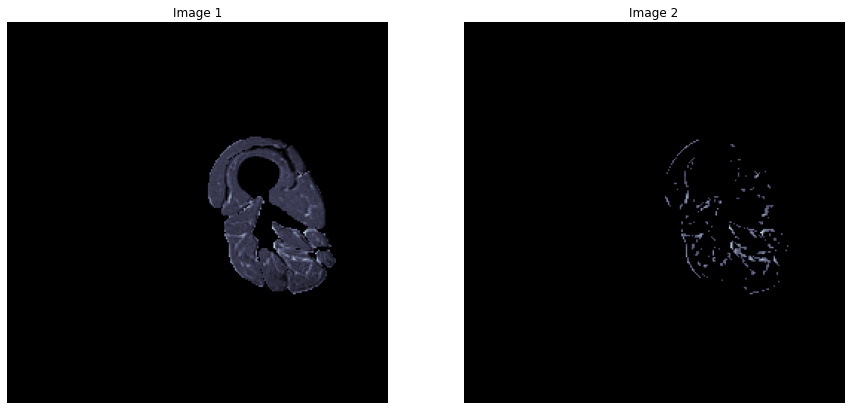

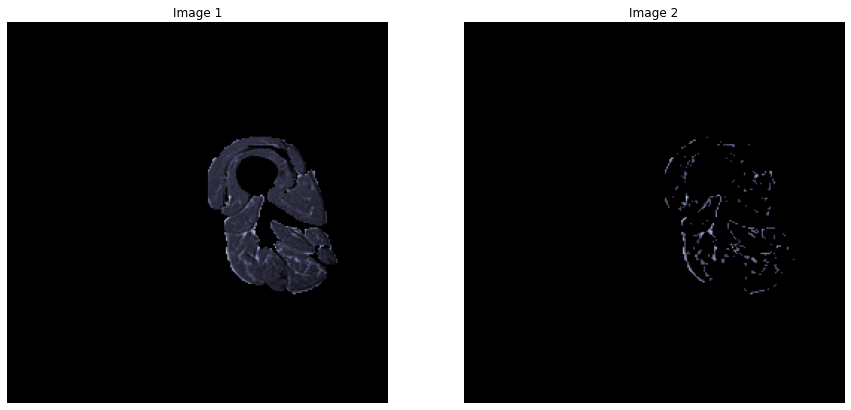

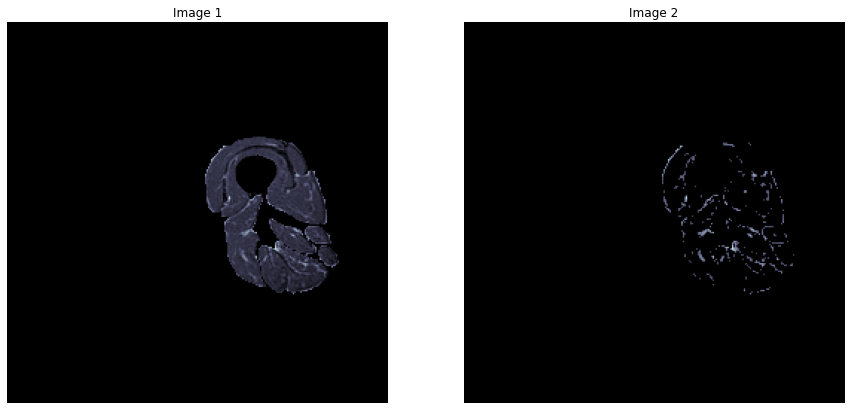

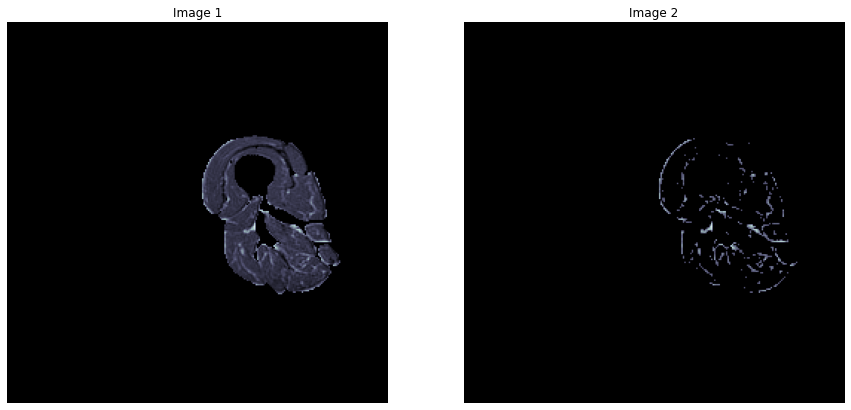

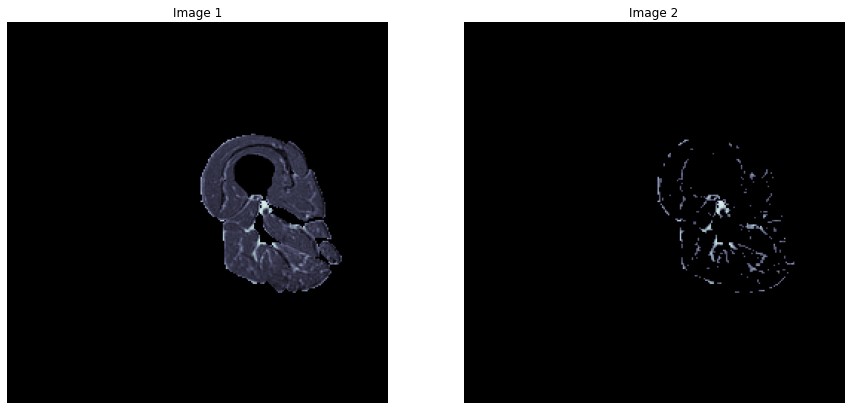

In [604]:
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(roi[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"Image 1")
    axs[0].axis("off")
    axs[1].imshow(fatseg1vol[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"Image 2")
    axs[1].axis("off")


# Threshold Optimization Round 2

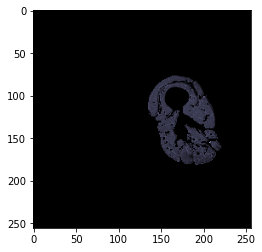

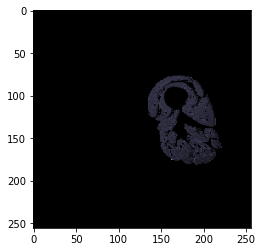

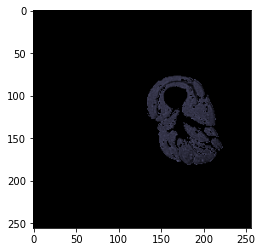

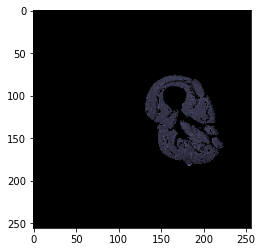

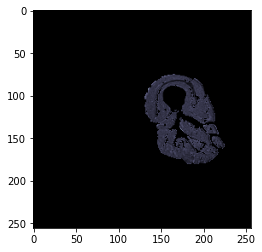

In [603]:
#Remove the first round of fat
roi2=roi-fatseg1vol
for i in range(j):  

    plt.imshow(roi2[i], cmap=plt.cm.bone,vmin=0,vmax=255)
    plt.show()

In [32]:
def ITSA_R2(i, roivar, ots, zcheck):
    k_R2=1
    ThPrev_R2=0 
    ThRev_R2= ots[i] 
    x_R2=0
    y_R2=0
    while ThRev_R2!=ThPrev_R2:
        ThPrev_R2=ThRev_R2
        prefatmask_R2 = (roi2[i]>ThRev_R2)
        prefatmask_R2 = np.uint8(prefatmask_R2)
        ret_R2, fatmask_R2 = cv2.threshold(prefatmask_R2,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next_R2=zcheck[i+1]+fatmask_R2
            ret_R2, fatconnectedparts_next_R2= cv2.threshold(fatcombined_next_R2,1,1,cv2.THRESH_BINARY)
            z_connection_R2=fatconnectedparts_next_R2
        elif i==(j-1):
            fatcombined_prev_R2=zcheck[i-1]+fatmask_R2
            ret_R2, fatconnectedparts_prev_R2= cv2.threshold(fatcombined_prev_R2,1,1,cv2.THRESH_BINARY)
            z_connection_R2=fatconnectedparts_prev_R2
        else:
            fatcombined_prev_R2=zcheck[i-1]+fatmask_R2
            fatcombined_next_R2=fatmask_R2+zcheck[i+1]
            ret_R2, fatconnectedparts_prev_R2= cv2.threshold(fatcombined_prev_R2,1,1,cv2.THRESH_BINARY)
            ret_R2, fatconnectedparts_next_R2= cv2.threshold(fatcombined_next_R2,1,1,cv2.THRESH_BINARY)

            z_connection_R2=fatconnectedparts_prev_R2+fatconnectedparts_next_R2
            ret_R2, z_connection_R2= cv2.threshold(z_connection_R2,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates_R2= np.argwhere(z_connection_R2 ==1) #put coordinates of Z-connections into a list      
        im_ff_R2=fatmask_R2.copy()
        h_R2, w_R2 = im_ff_R2.shape[:2] #added
        mask_R2 = np.zeros((h_R2+2, w_R2+2), np.uint8)
        for item in range(len(coordinates_R2)):
            cv2.floodFill(im_ff_R2, mask_R2, (coordinates_R2[item][1],coordinates_R2[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ_R2 =label(im_ff_R2==1)
        nonZ_keep_R2 = (morphology.remove_small_objects(nonZ_R2,min_size=8, connectivity=1))
        ret_R2, nonZ_keep_R2= cv2.threshold(np.uint8(nonZ_keep_R2),0,1,cv2.THRESH_BINARY)
        Z_R2 = (im_ff_R2==2)
        prefatseg1_R2=(Z_R2+nonZ_keep_R2) #do we need int cus boolean??
        fatseg1_R2=prefatseg1_R2*roi2[i]
        #Fat and Muscle Quantification
        preMuscSegP_R2=roi2[i]-fatseg1_R2
        MuscSegP_R2=np.ma.masked_where(preMuscSegP_R2 == 0, preMuscSegP_R2)
        FatSegP_R2=np.ma.masked_where(fatseg1_R2==0,fatseg1_R2) 
        MuscSegI_R2=np.mean(MuscSegP_R2)
        FatSegI_R2=np.mean(FatSegP_R2)
        ThRev_R2=(1+((FatSegI_R2-MuscSegI_R2)/FatSegI_R2))*MuscSegI_R2
        print (f"Slice #{i+1} Iteration={k_R2}\n\tThPrev={ThPrev_R2}\n\tThRev={ThRev_R2}\n")

        k_R2+=1
        if k_R2==50:
            break

    thresholds_R2=ThRev_R2
    return prefatseg1_R2, fatseg1_R2, thresholds_R2

[24.78125 58.09375]
Slice 1 otsu threshold=58.09375
[19.83007812 48.87695312]
Slice 2 otsu threshold=48.876953125
[21.078125 51.953125]
Slice 3 otsu threshold=51.953125
[25.04882812 59.85351562]
Slice 4 otsu threshold=59.853515625
[27.2109375 64.8359375]
Slice 5 otsu threshold=64.8359375


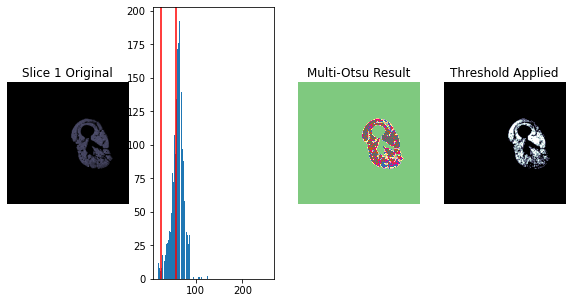

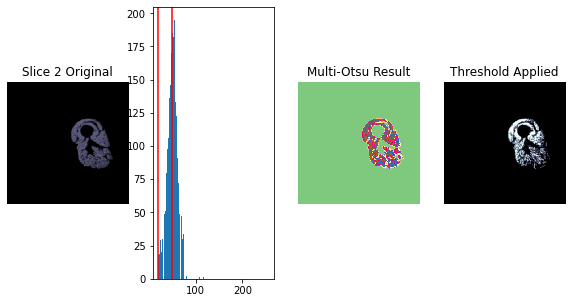

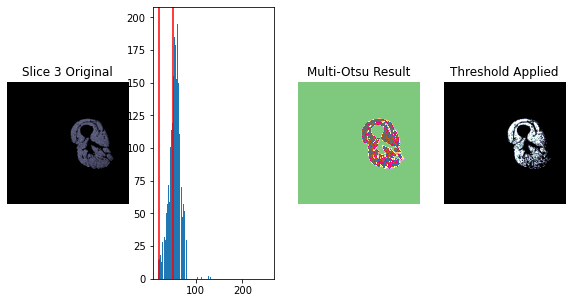

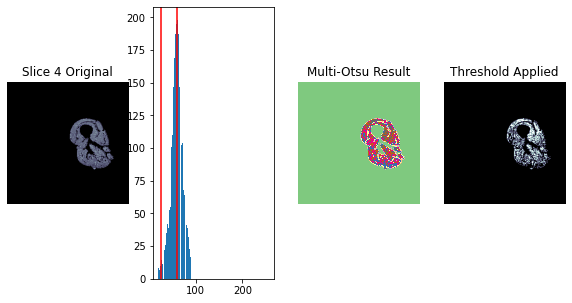

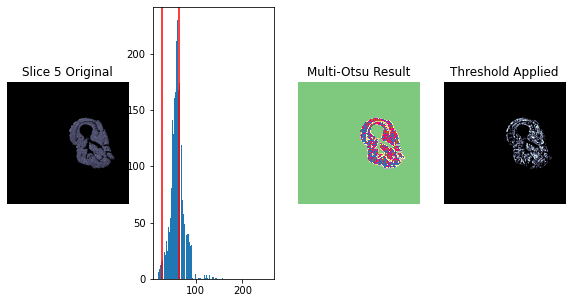

In [33]:
ithresholdR2=[]
for i in range(j):
ithresholdR2.append([])
  ithresholdR2[i]=multi_otsu(roi2[i])

In [34]:
fatseg1vol_maskR2=np.zeros([roi2.shape[0], roi2.shape[1], roi2.shape[2]], dtype='uint8')
fatseg1volR2=np.zeros([roi2.shape[0], roi2.shape[1], roi2.shape[2]], dtype='uint8') #change name

thresholds_R2=[] #change name compared to single slice?
for i in range(j):
    thresholds_R2.append([])
    fatseg1vol_maskR2[i],fatseg1volR2[i], thresholds_R2[i]=ITSA_R2(i,roi2,ithresholdR2,merged_array1)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Th1 R2= {ithresholdR2[i]}")
    print ("-----------------------------------------------------------")

for i in range(j):
    print (f"Slice #{i+1} Th1 R2 OG/Rev={ithresholdR2[i]}")

Slice #1 Iteration=1
	ThPrev=58.09375
	ThRev=61.179695589451946

Slice #1 Iteration=2
	ThPrev=61.179695589451946
	ThRev=63.908866042242664

Slice #1 Iteration=3
	ThPrev=63.908866042242664
	ThRev=65.75033703766155

Slice #1 Iteration=4
	ThPrev=65.75033703766155
	ThRev=67.49535667776993

Slice #1 Iteration=5
	ThPrev=67.49535667776993
	ThRev=69.22268532499061

Slice #1 Iteration=6
	ThPrev=69.22268532499061
	ThRev=70.75886119914952

Slice #1 Iteration=7
	ThPrev=70.75886119914952
	ThRev=71.5050934399158

Slice #1 Iteration=8
	ThPrev=71.5050934399158
	ThRev=72.28814182064902

Slice #1 Iteration=9
	ThPrev=72.28814182064902
	ThRev=72.93069158875475

Slice #1 Iteration=10
	ThPrev=72.93069158875475
	ThRev=72.93069158875475

Slice #1 Th1 R2= 58.09375
-----------------------------------------------------------
Slice #2 Iteration=1
	ThPrev=48.876953125
	ThRev=50.94715342767077

Slice #2 Iteration=2
	ThPrev=50.94715342767077
	ThRev=52.62906592044481

Slice #2 Iteration=3
	ThPrev=52.62906592044481
	T

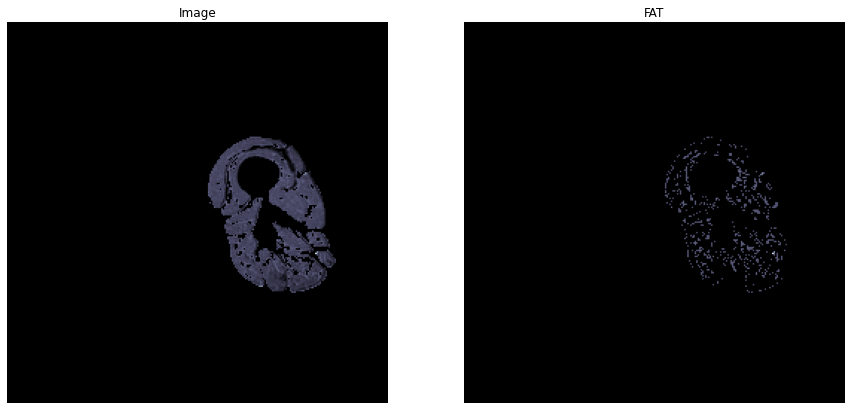

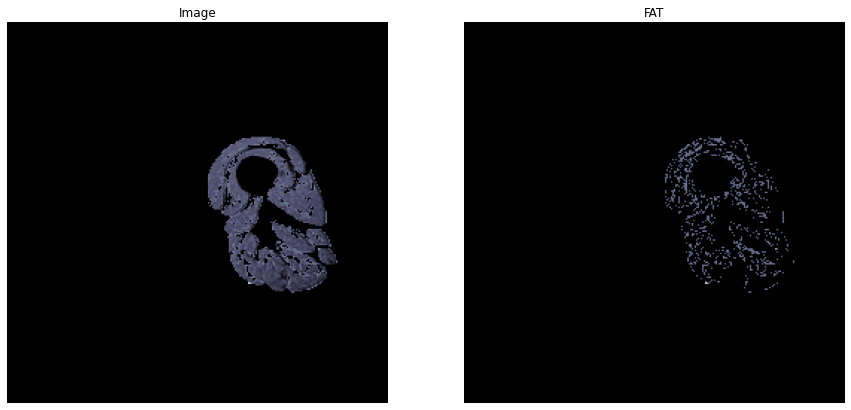

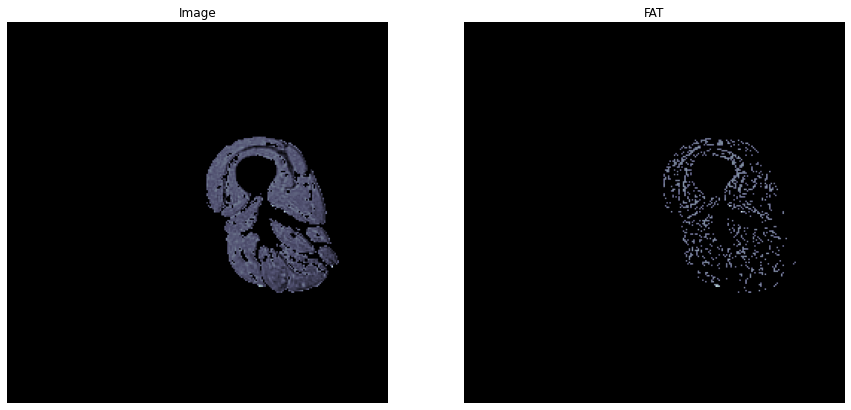

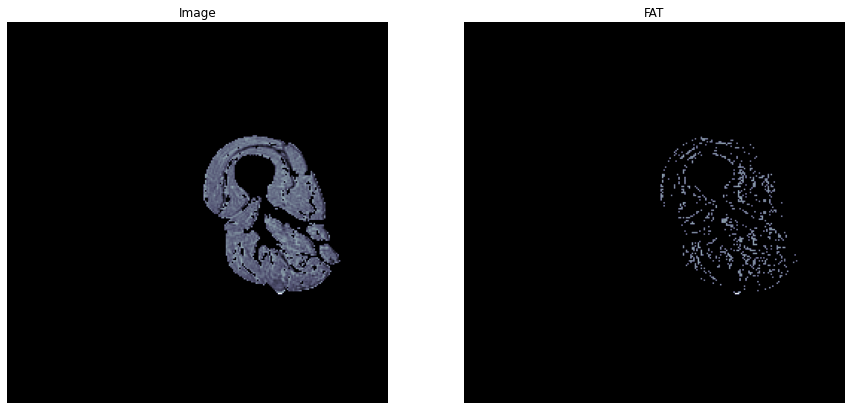

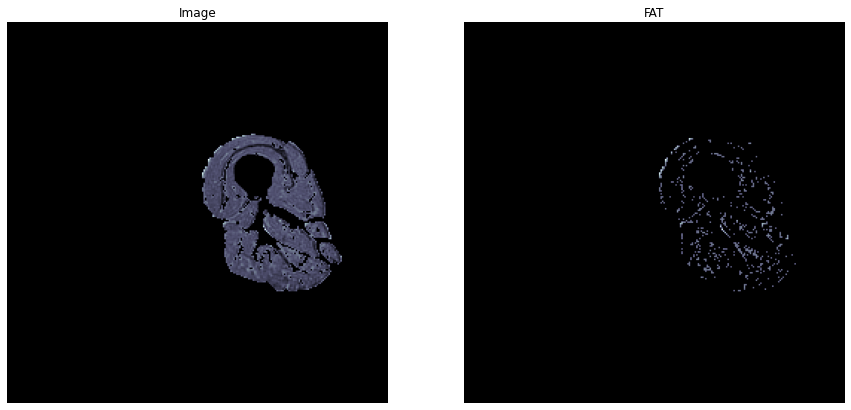

In [35]:
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(roi2[i],"bone",)
    axs[0].set_title(f"Image")
    axs[0].axis("off")
    axs[1].imshow(fatseg1volR2[i],"bone")
    axs[1].set_title(f"FAT")
    axs[1].axis("off")

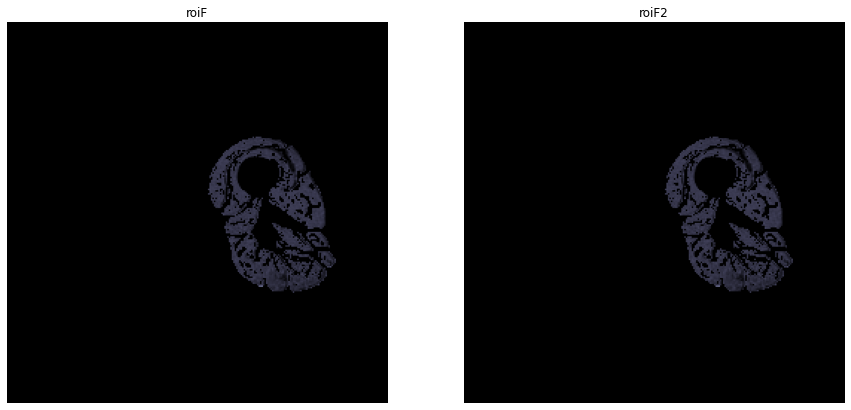

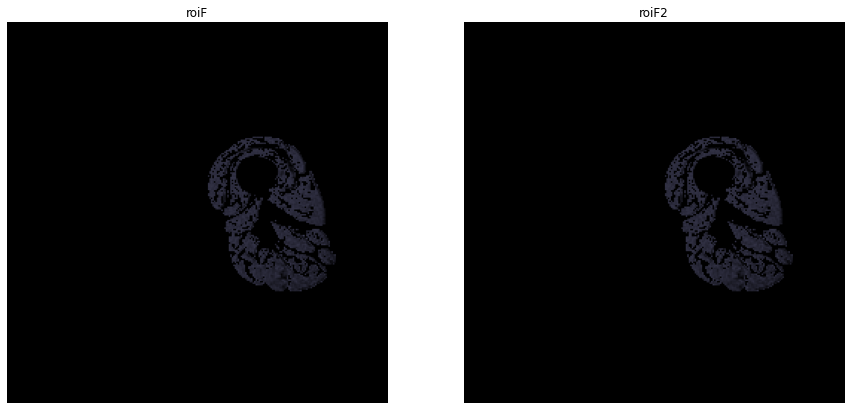

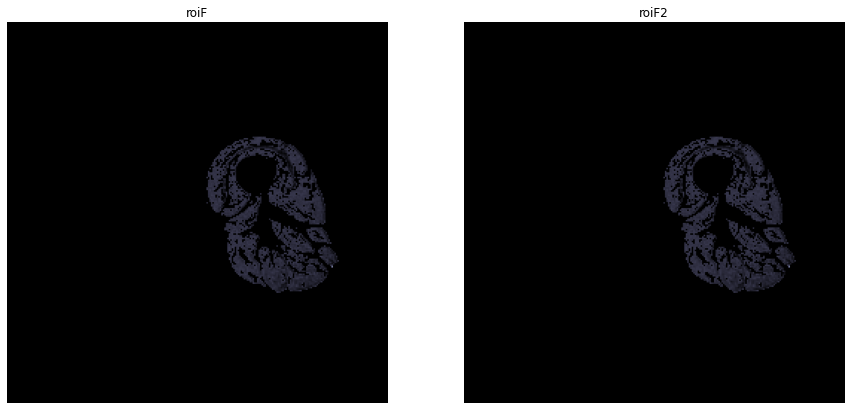

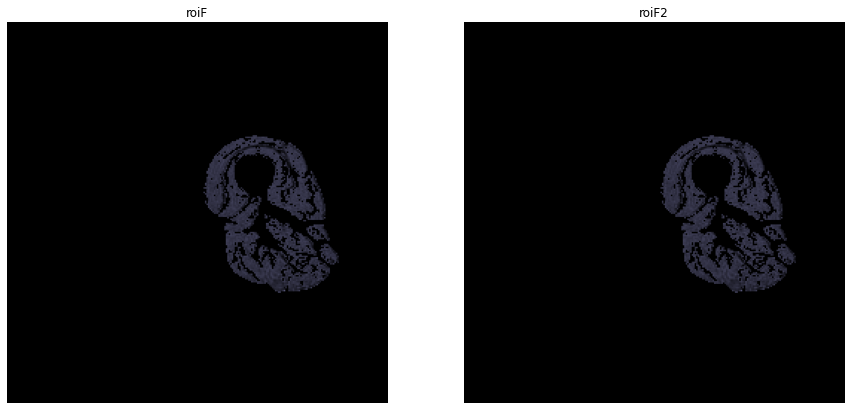

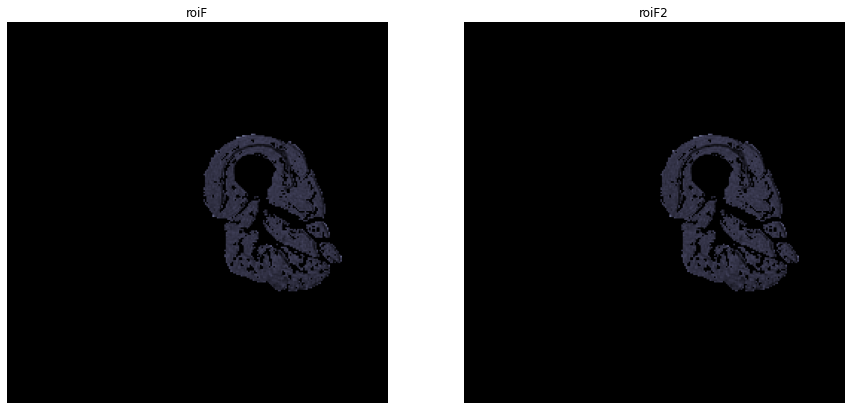

In [36]:
#Visualization of Fat Removed
for i in range (j): #Method 1
    test=1-fatseg1vol_maskR2
    roiF=roi2*test
for i in range (j): #Method 2
    roiF2=roi2-fatseg1volR2

#Confirmation that the brighter MRI's are not due to misprocessing?
for i in range (5):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(roiF[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"roiF")
    axs[0].axis("off")
    axs[1].imshow(roiF2[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"roiF2")
    axs[1].axis("off")

In [ ]:
for i in range (1):
    fig, axs=plt.subplots (1,3, figsize=(15,10))
    axs[0].imshow(roi[i],"bone",)
    axs[0].set_title(f"ROI")
    axs[0].axis("off")
    axs[1].imshow(roiF[i],"bone")
    axs[1].set_title(f"roiF")
    axs[1].axis("off")
    axs[2].imshow(fatseg1vol[i],"bone")
    axs[2].set_title(f"fatseg1vol")
    axs[2].axis("off")
    axs[3].imshow(fatseg1volR2[i],"bone")
    axs[3].set_title(f"fatseg1volR2")
    axs[3].axis("off")

# # ITSA Implementation (Inverse Merged MSK)

# Inhomogenity Correction for Subcut. Fat

In [505]:
#Get rid of background magnetic noise
invroi2 = np.where(invroi < 80, 0, invroi)

[  1.49414062 154.89257812]
Slice 1 otsu threshold=154.892578125
[  1.49414062 151.90429688]
Slice 2 otsu threshold=151.904296875
[  1.49414062 155.88867188]
Slice 3 otsu threshold=155.888671875
[  1.49414062 162.86132812]
Slice 4 otsu threshold=162.861328125
[  1.49414062 161.86523438]
Slice 5 otsu threshold=161.865234375


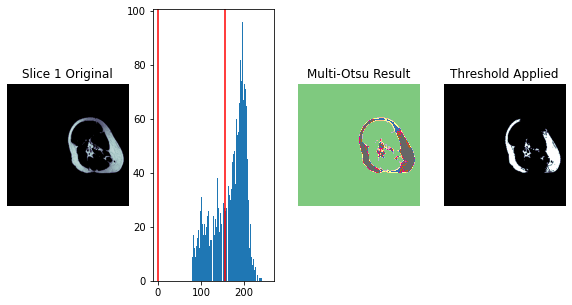

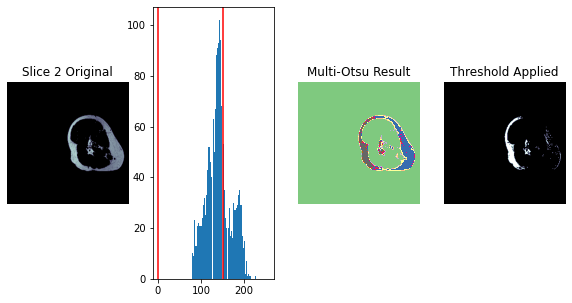

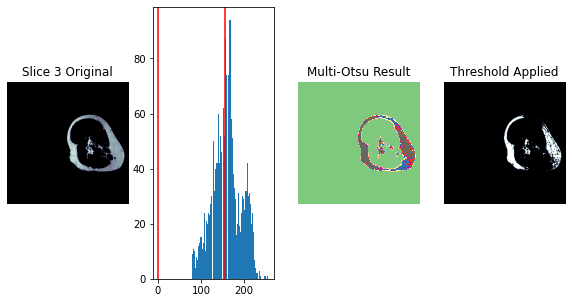

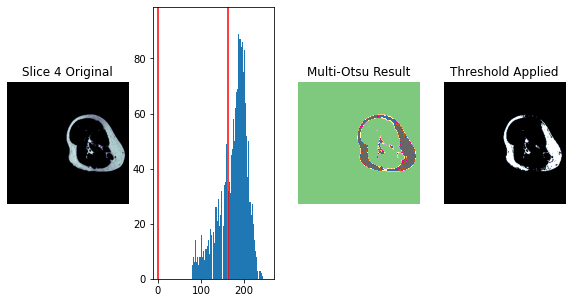

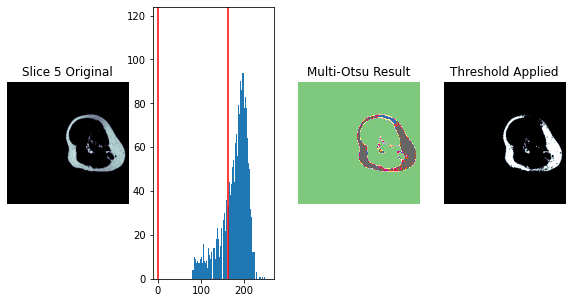

In [506]:
initial_thINV=[]

for i in range(j):
    initial_thINV.append([])
    initial_thINV[i]=multi_otsu(invroi2[i])

In [507]:
def ITSA_INV(i, roivar, ots, zcheck):
    k_INV=1
    ThPrev_INV=0 
    ThRev_INV= ots[i] 
    x_INV=0
    y_INV=0
    while ThRev_INV!=ThPrev_INV:
        ThPrev_INV=ThRev_INV
        prefatmask_INV = (invroi2[i]>ThRev_INV)
        prefatmask_INV = np.uint8(prefatmask_INV)
        ret_INV, fatmask_INV = cv2.threshold(prefatmask_INV,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next_INV=zcheck[i+1]+fatmask_INV
            ret_INV, fatconnectedparts_next_INV= cv2.threshold(fatcombined_next_INV,1,1,cv2.THRESH_BINARY)
            z_connection_INV=fatconnectedparts_next_INV
        elif i==(j-1):
            fatcombined_prev_INV=zcheck[i-1]+fatmask_INV
            ret_INV, fatconnectedparts_prev_INV= cv2.threshold(fatcombined_prev_INV,1,1,cv2.THRESH_BINARY)
            z_connection_INV=fatconnectedparts_prev_INV
        else:
            fatcombined_prev_INV=zcheck[i-1]+fatmask_INV
            fatcombined_next_INV=fatmask_INV+zcheck[i+1]
            ret_INV, fatconnectedparts_prev_INV= cv2.threshold(fatcombined_prev_INV,1,1,cv2.THRESH_BINARY)
            ret_INV, fatconnectedparts_next_INV= cv2.threshold(fatcombined_next_INV,1,1,cv2.THRESH_BINARY)

            z_connection_INV=fatconnectedparts_prev_INV+fatconnectedparts_next_INV
            ret_INV, z_connection_INV= cv2.threshold(z_connection_INV,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates_INV= np.argwhere(z_connection_INV ==1) #put coordinates of Z-connections into a list      
        im_ff_INV=fatmask_INV.copy()
        h_INV, w_INV = im_ff_INV.shape[:2] #added
        mask_INV = np.zeros((h_INV+2, w_INV+2), np.uint8)
        for item in range(len(coordinates_INV)):
            cv2.floodFill(im_ff_INV, mask_INV, (coordinates_INV[item][1],coordinates_INV[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ_INV =label(im_ff_INV==1)
        nonZ_keep_INV = (morphology.remove_small_objects(nonZ_INV,min_size=8, connectivity=1))
        ret_INV, nonZ_keep_INV= cv2.threshold(np.uint8(nonZ_keep_INV),0,1,cv2.THRESH_BINARY)
        Z_INV = (im_ff_INV==2)
        prefatseg1_INV=(Z_INV+nonZ_keep_INV) #do we need int cus boolean??
        fatseg1_INV=prefatseg1_INV*invroi[i]
        #Fat and Muscle Quantification
        preMuscSegP_INV=invroi[i]-fatseg1_INV
        MuscSegP_INV=np.ma.masked_where(preMuscSegP_INV == 0, preMuscSegP_INV)
        FatSegP_INV=np.ma.masked_where(fatseg1_INV==0,fatseg1_INV) 
        MuscSegI_INV=np.mean(MuscSegP_INV)
        FatSegI_INV=np.mean(FatSegP_INV)
        ThRev_INV=(1+((FatSegI_INV-MuscSegI_INV)/FatSegI_INV))*MuscSegI_INV
        print (f"Slice #{i+1} Iteration={k_INV}\n\tThPrev={ThPrev_INV}\n\tThRev={ThRev_INV}\n")

        k_INV+=1
        if k_INV==50:
            break

    thresholds_INV=ThRev_INV
    return prefatseg1_INV, fatseg1_INV, thresholds_INV

In [508]:
fatseg1vol_maskINV=np.zeros([invroi2.shape[0], invroi2.shape[1], invroi2.shape[2]], dtype='uint8')
fatseg1volINV=np.zeros([invroi2.shape[0], invroi2.shape[1], invroi2.shape[2]], dtype='uint8') #change name

thresholds_INV=[] #change name compared to single slice?
for i in range(j):
    thresholds_INV.append([])
    fatseg1vol_maskINV[i],fatseg1volINV[i], thresholds_INV[i]=ITSA_INV(i,invroi2,initial_thINV,invmask)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Th1 R2= {initial_thINV[i]}")
    print ("-----------------------------------------------------------")

for i in range(j):
    print (f"Slice #{i+1} Th1 R2 OG/Rev={initial_thINV[i]}")

Slice #1 Iteration=1
	ThPrev=154.892578125
	ThRev=16.90928036345285

Slice #1 Iteration=2
	ThPrev=16.90928036345285
	ThRev=10.681215384100877

Slice #1 Iteration=3
	ThPrev=10.681215384100877
	ThRev=10.681215384100877

Slice #1 Th1 R2= 154.892578125
-----------------------------------------------------------
Slice #2 Iteration=1
	ThPrev=151.904296875
	ThRev=23.943700941893074

Slice #2 Iteration=2
	ThPrev=23.943700941893074
	ThRev=11.265292318733112

Slice #2 Iteration=3
	ThPrev=11.265292318733112
	ThRev=11.265292318733112

Slice #2 Th1 R2= 151.904296875
-----------------------------------------------------------
Slice #3 Iteration=1
	ThPrev=155.888671875
	ThRev=20.893624909443577

Slice #3 Iteration=2
	ThPrev=20.893624909443577
	ThRev=12.057218698672624

Slice #3 Iteration=3
	ThPrev=12.057218698672624
	ThRev=12.057218698672624

Slice #3 Th1 R2= 155.888671875
-----------------------------------------------------------
Slice #4 Iteration=1
	ThPrev=162.861328125
	ThRev=19.058167370719058


<ipython-input-507-cd9f3e4f125e>:37: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nonZ_keep_INV = (morphology.remove_small_objects(nonZ_INV,min_size=8, connectivity=1))


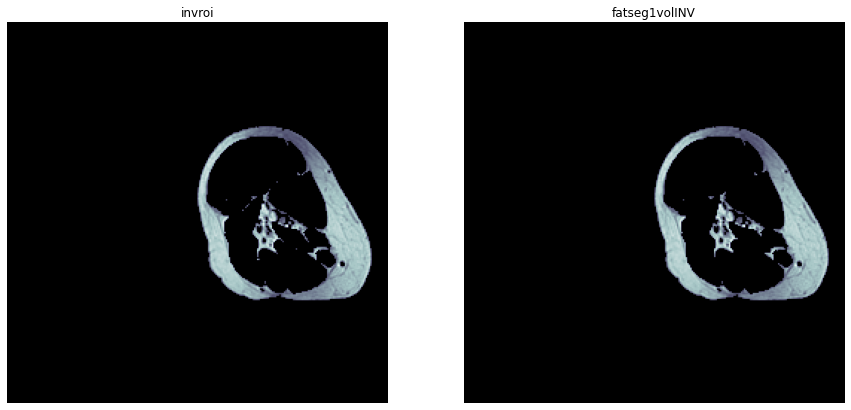

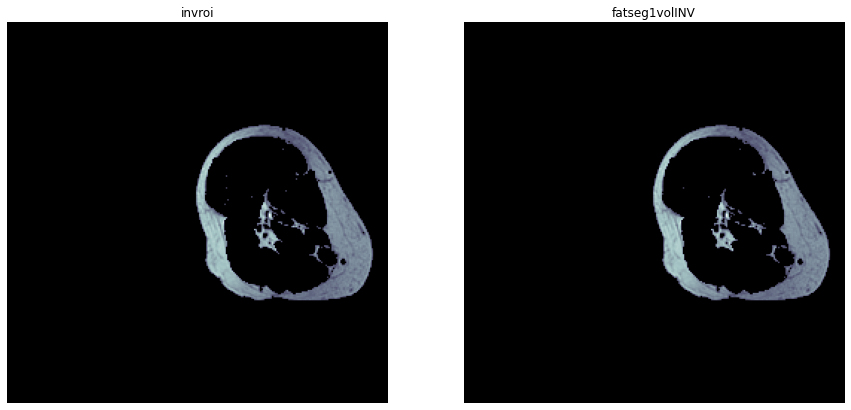

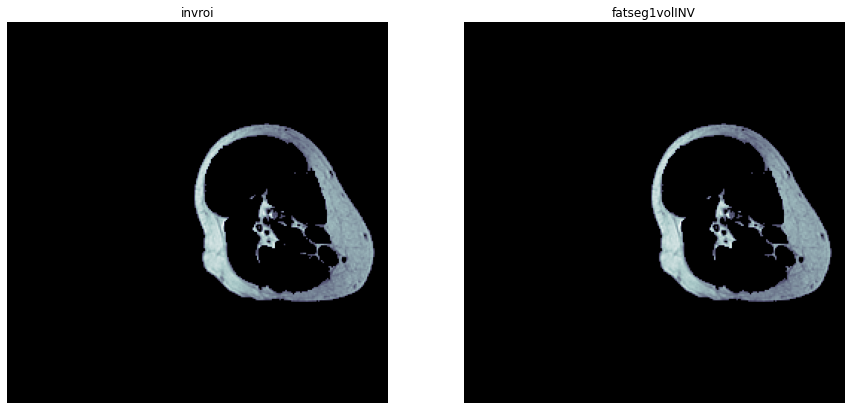

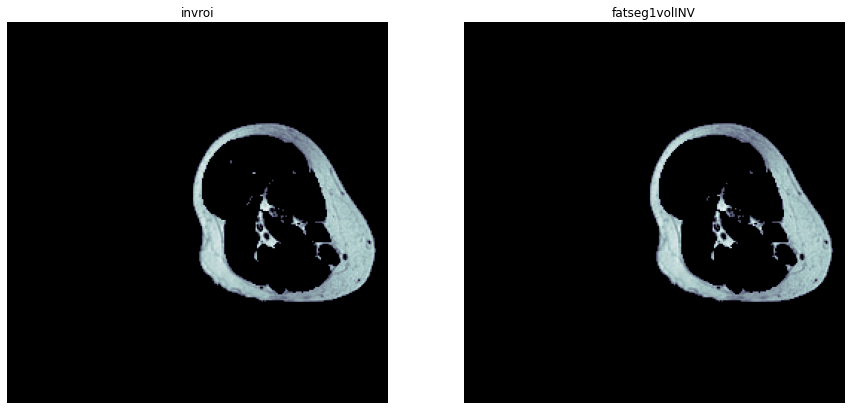

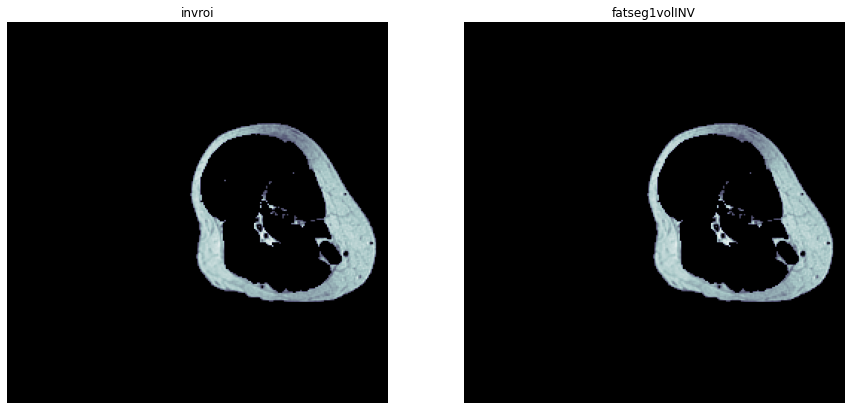

In [509]:
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(invroi2[i],"bone",)
    axs[0].set_title(f"invroi")
    axs[0].axis("off")
    axs[1].imshow(fatseg1volINV[i],"bone")
    axs[1].set_title(f"fatseg1volINV")
    axs[1].axis("off")

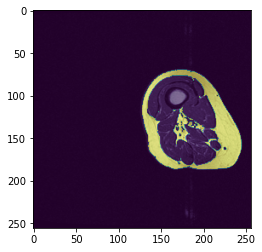

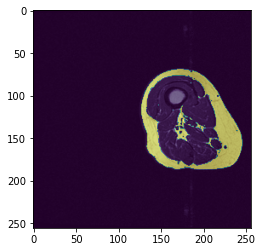

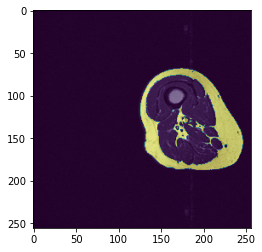

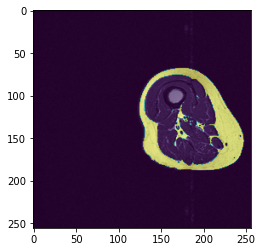

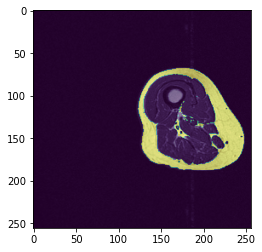

In [510]:
for i in range (5):
    plt.imshow(inputs1[i],cmap=plt.cm.bone)
    plt.imshow(fatseg1vol_maskINV[i],alpha=0.5)
    plt.show()

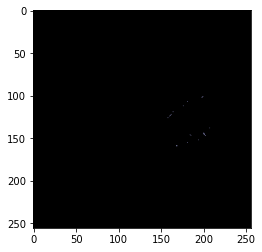

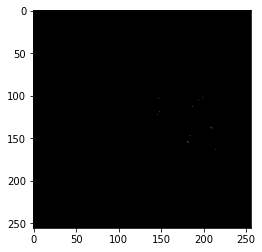

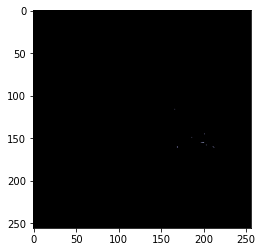

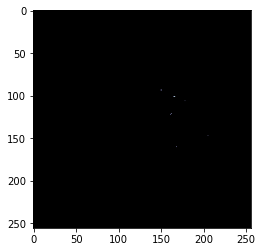

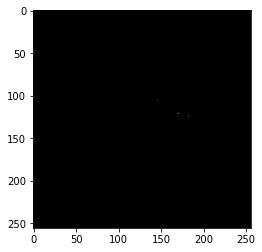

In [512]:
invroiR1=invroi2-fatseg1volINV
for i in range (5):
    plt.imshow(fatseg1volINV[i],cmap=plt.cm.Reds,vmin=0, vmax=255)
    plt.imshow(invroiR1[i],cmap=plt.cm.bone,vmin=0, vmax=255)
    plt.show()

# ITSA Implementation (Inverse Merged MSK) Round 2

[  1 155]
Slice 1 otsu threshold=155
[  1 152]
Slice 2 otsu threshold=152
[  1 156]
Slice 3 otsu threshold=156
[  1 163]
Slice 4 otsu threshold=163
[  1 162]
Slice 5 otsu threshold=162


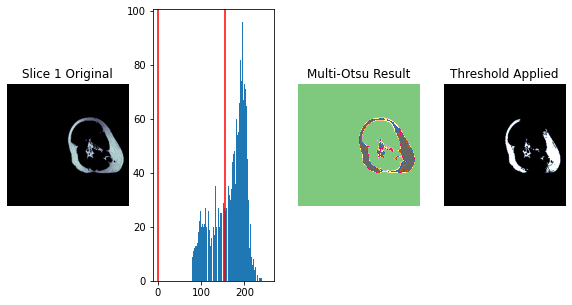

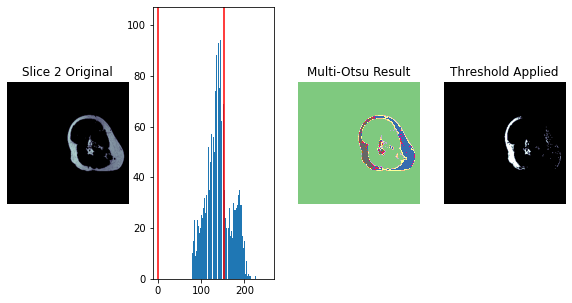

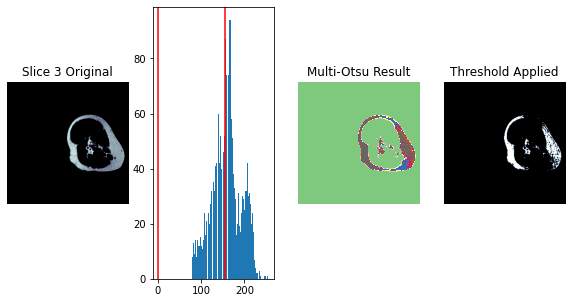

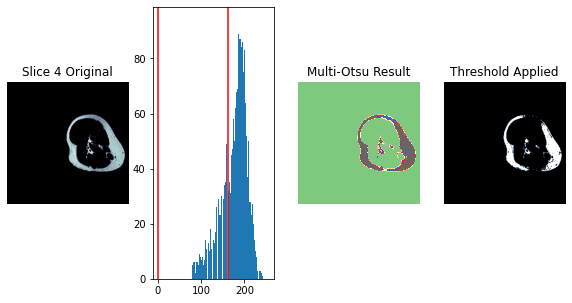

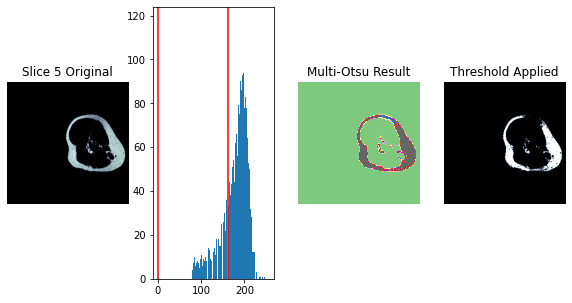

In [517]:
initial_thINV_R2=[]

for i in range(j):
    initial_thINV_R2.append([])
    initial_thINV_R2[i]=multi_otsu(fatseg1volINV[i])

In [530]:
def ITSA_INV_R2(i, roivar, ots, zcheck):
    k_INV_R2=1
    ThPrev_INV_R2=0 
    ThRev_INV_R2= ots[i] 
    x_INV_R2=0
    y_INV_R2=0
    while ThRev_INV_R2!=ThPrev_INV_R2:
        ThPrev_INV_R2=ThRev_INV_R2
        prefatmask_INV_R2 = (fatseg1volINV[i]>ThRev_INV_R2)
        prefatmask_INV_R2 = np.uint8(prefatmask_INV_R2)
        ret_INV_R2, fatmask_INV_R2 = cv2.threshold(prefatmask_INV_R2,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next_INV_R2=zcheck[i+1]+fatmask_INV_R2
            ret_INV_R2, fatconnectedparts_next_INV_R2= cv2.threshold(fatcombined_next_INV_R2,1,1,cv2.THRESH_BINARY)
            z_connection_INV_R2=fatconnectedparts_next_INV_R2
        elif i==(j-1):
            fatcombined_prev_INV_R2=zcheck[i-1]+fatmask_INV_R2
            ret_INV_R2, fatconnectedparts_prev_INV_R2= cv2.threshold(fatcombined_prev_INV_R2,1,1,cv2.THRESH_BINARY)
            z_connection_INV_R2=fatconnectedparts_prev_INV_R2
        else:
            fatcombined_prev_INV_R2=zcheck[i-1]+fatmask_INV_R2
            fatcombined_next_INV_R2=fatmask_INV_R2+zcheck[i+1]
            ret_INV_R2, fatconnectedparts_prev_INV_R2= cv2.threshold(fatcombined_prev_INV_R2,1,1,cv2.THRESH_BINARY)
            ret_INV_R2, fatconnectedparts_next_INV_R2= cv2.threshold(fatcombined_next_INV_R2,1,1,cv2.THRESH_BINARY)

            z_connection_INV_R2=fatconnectedparts_prev_INV_R2+fatconnectedparts_next_INV_R2
            ret_INV_R2, z_connection_INV_R2= cv2.threshold(z_connection_INV_R2,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates_INV_R2= np.argwhere(z_connection_INV_R2 ==1) #put coordinates of Z-connections into a list      
        im_ff_INV_R2=fatmask_INV_R2.copy()
        h_INV_R2, w_INV_R2 = im_ff_INV_R2.shape[:2] #added
        mask_INV_R2 = np.zeros((h_INV_R2+2, w_INV_R2+2), np.uint8)
        for item in range(len(coordinates_INV_R2)):
            cv2.floodFill(im_ff_INV_R2, mask_INV_R2, (coordinates_INV_R2[item][1],coordinates_INV_R2[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ_INV_R2 =label(im_ff_INV_R2==1)
        nonZ_keep_INV_R2 = (morphology.remove_small_objects(nonZ_INV_R2,min_size=8, connectivity=1))
        ret_INV_R2, nonZ_keep_INV_R2= cv2.threshold(np.uint8(nonZ_keep_INV_R2),0,1,cv2.THRESH_BINARY)
        Z_INV_R2 = (im_ff_INV_R2==2)
        prefatseg1_INV_R2=(Z_INV_R2+nonZ_keep_INV_R2) #do we need int cus boolean??
        fatseg1_INV_R2=prefatseg1_INV_R2*fatseg1volINV[i]
        #Fat and Muscle Quantification
        preMuscSegP_INV_R2=fatseg1volINV[i]-fatseg1_INV_R2
        MuscSegP_INV_R2=np.ma.masked_where(preMuscSegP_INV_R2 == 0, preMuscSegP_INV_R2)
        FatSegP_INV_R2=np.ma.masked_where(fatseg1_INV_R2==0,fatseg1_INV_R2) 
        MuscSegI_INV_R2=np.mean(MuscSegP_INV_R2)
        FatSegI_INV_R2=np.mean(FatSegP_INV_R2)
        ThRev_INV_R2=(1+((FatSegI_INV_R2-MuscSegI_INV_R2)/FatSegI_INV_R2))*MuscSegI_INV_R2
        print (f"Slice #{i+1} Iteration={k_INV_R2}\n\tThPrev={ThPrev_INV_R2}\n\tThRev={ThRev_INV_R2}\n")

        k_INV_R2+=1
        if k_INV_R2==50:
            break

    thresholds_INV_R2=ThRev_INV_R2
    return prefatseg1_INV_R2, fatseg1_INV_R2, thresholds_INV_R2

In [531]:
fatseg1vol_maskINV_R2=np.zeros([invroi2.shape[0], invroi2.shape[1], invroi2.shape[2]], dtype='uint8')
fatseg1volINV_R2=np.zeros([invroi2.shape[0], invroi2.shape[1], invroi2.shape[2]], dtype='uint8') #change name

thresholds_INV_R2=[] #change name compared to single slice?
for i in range(j):
    thresholds_INV_R2.append([])
    fatseg1vol_maskINV_R2[i],fatseg1volINV_R2[i], thresholds_INV_R2[i]=ITSA_INV_R2(i,fatseg1volINV,initial_thINV_R2,invmask)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Th1 R2= {initial_thINV_R2[i]}")
    print ("-----------------------------------------------------------")

for i in range(j):
    print (f"Slice #{i+1} Th1 R2 OG/Rev={initial_thINV_R2[i]}")

<ipython-input-530-4670feb4b417>:37: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nonZ_keep_INV_R2 = (morphology.remove_small_objects(nonZ_INV_R2,min_size=8, connectivity=1))


Slice #1 Iteration=1
	ThPrev=155
	ThRev=165.18731617874414

Slice #1 Iteration=2
	ThPrev=165.18731617874414
	ThRev=170.1794934678934

Slice #1 Iteration=3
	ThPrev=170.1794934678934
	ThRev=173.4787495715458

Slice #1 Iteration=4
	ThPrev=173.4787495715458
	ThRev=175.55253753957936

Slice #1 Iteration=5
	ThPrev=175.55253753957936
	ThRev=176.98516659208423

Slice #1 Iteration=6
	ThPrev=176.98516659208423
	ThRev=177.75189507216336

Slice #1 Iteration=7
	ThPrev=177.75189507216336
	ThRev=178.44413730733956

Slice #1 Iteration=8
	ThPrev=178.44413730733956
	ThRev=179.0826203866232

Slice #1 Iteration=9
	ThPrev=179.0826203866232
	ThRev=179.84718854607007

Slice #1 Iteration=10
	ThPrev=179.84718854607007
	ThRev=179.84718854607007

Slice #1 Th1 R2= 155
-----------------------------------------------------------
Slice #2 Iteration=1
	ThPrev=152
	ThRev=163.53498794171938

Slice #2 Iteration=2
	ThPrev=163.53498794171938
	ThRev=167.79511283212793

Slice #2 Iteration=3
	ThPrev=167.79511283212793
	ThRev

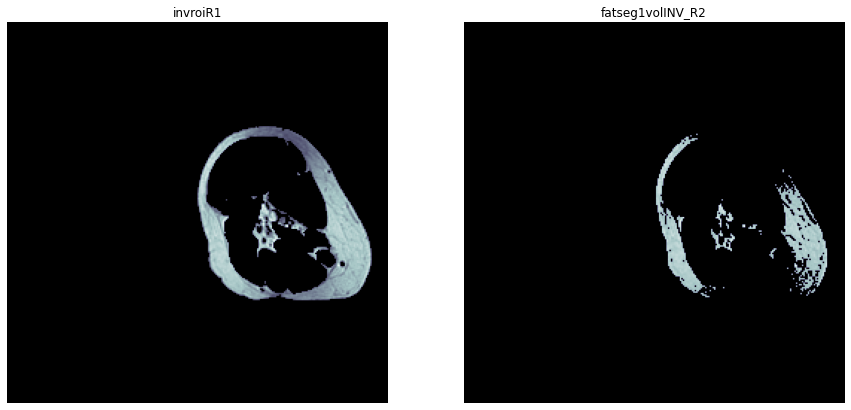

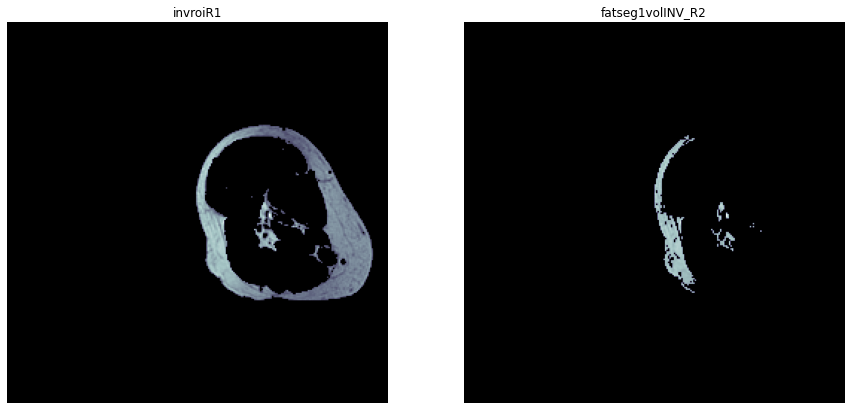

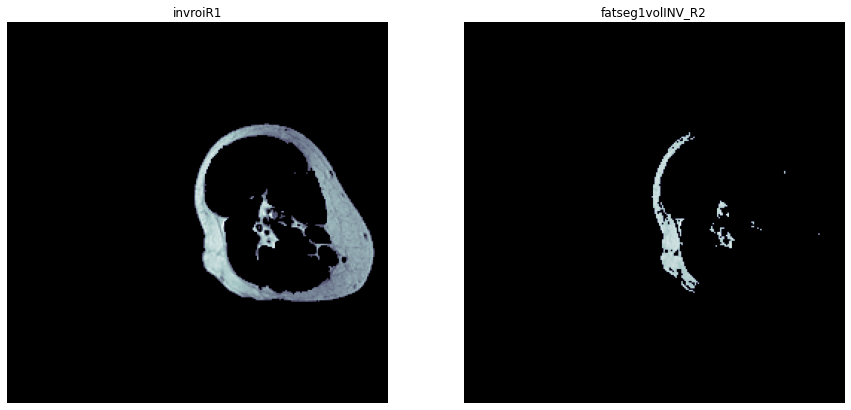

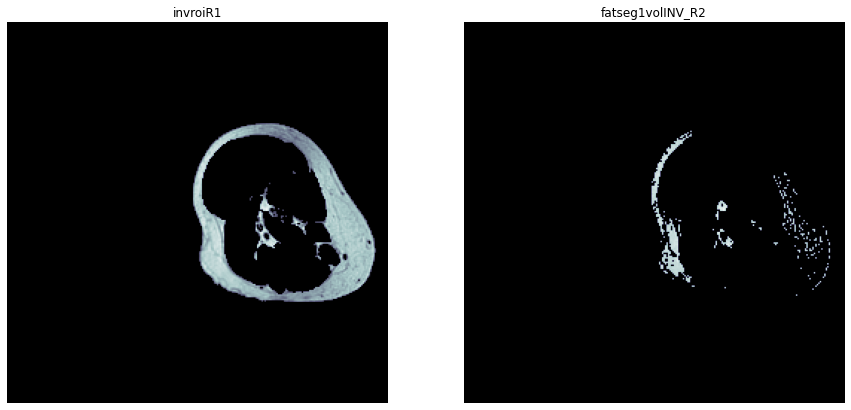

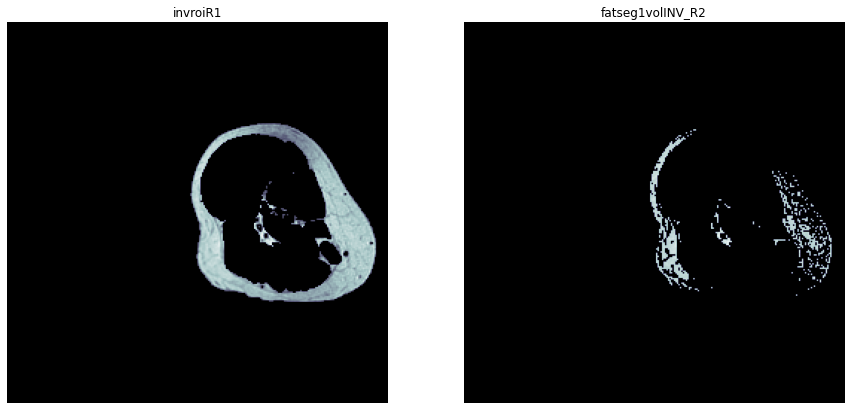

In [532]:
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(fatseg1volINV[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"invroiR1")
    axs[0].axis("off")
    axs[1].imshow(fatseg1volINV_R2[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"fatseg1volINV_R2")
    axs[1].axis("off")

In [ ]:
#NEED TO RUN INHOMOGENEITY AGAIN..

# # ITSA Implementation (RF)

In [547]:
rf=outputs[: , :, :, 0]
ROIrf=rf*inputs1

[14.05859375 39.87109375]
Slice 1 otsu threshold=39.87109375
[16.1328125 44.0234375]
Slice 2 otsu threshold=44.0234375
[17.03710938 47.75976562]
Slice 3 otsu threshold=47.759765625
[18.9375 51.1875]
Slice 4 otsu threshold=51.1875
[16.2265625 53.0390625]
Slice 5 otsu threshold=53.0390625


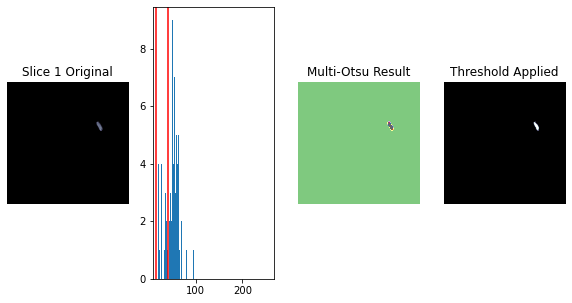

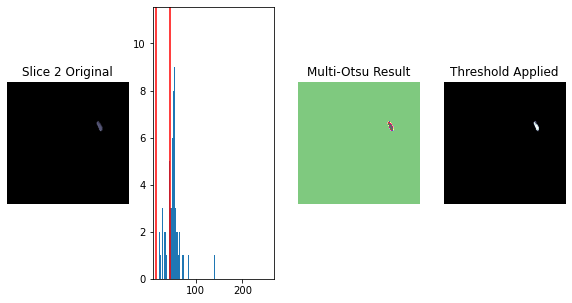

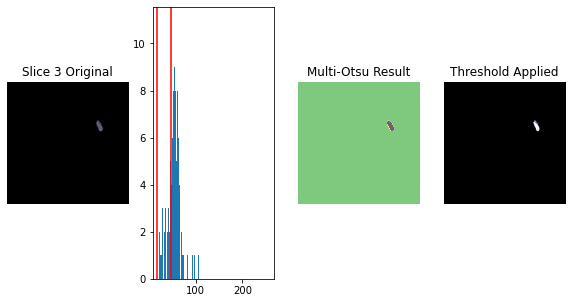

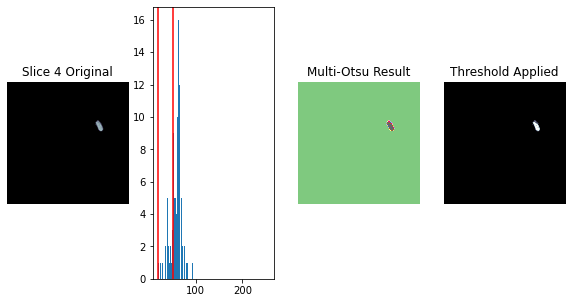

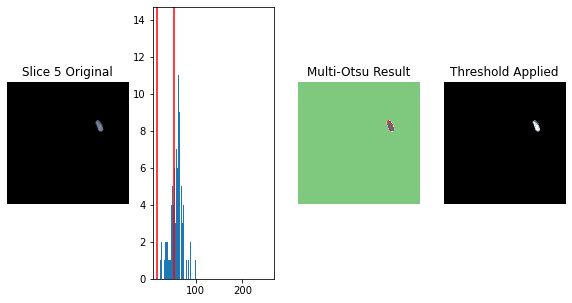

In [548]:
iThreshold_RF=[]
for i in range(j):
    iThreshold_RF.append([])
    iThreshold_RF[i]=multi_otsu(ROIrf[i])

In [549]:
def ITSA_RF(i, roivar, ots, zcheck):
    k_RF=1
    ThPrev_RF=0 
    ThRev_RF= ots[i] 
    x_RF=0
    y_RF=0
    while ThRev_RF!=ThPrev_RF:
        ThPrev_RF=ThRev_RF
        prefatmask_RF = (ROIrf[i]>ThRev_RF)
        prefatmask_RF = np.uint8(prefatmask_RF)
        ret_RF, fatmask_RF = cv2.threshold(prefatmask_RF,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next_RF=zcheck[i+1]+fatmask_RF
            ret_RF, fatconnectedparts_next_RF= cv2.threshold(fatcombined_next_RF,1,1,cv2.THRESH_BINARY)
            z_connection_RF=fatconnectedparts_next_RF
        elif i==(j-1):
            fatcombined_prev_RF=zcheck[i-1]+fatmask_RF
            ret_RF, fatconnectedparts_prev_RF= cv2.threshold(fatcombined_prev_RF,1,1,cv2.THRESH_BINARY)
            z_connection_RF=fatconnectedparts_prev_RF 
        else:
            fatcombined_prev_RF=zcheck[i-1]+fatmask_RF
            fatcombined_next_RF=fatmask_RF+zcheck[i+1]
            ret_RF, fatconnectedparts_prev_RF= cv2.threshold(fatcombined_prev_RF,1,1,cv2.THRESH_BINARY)
            ret_RF, fatconnectedparts_next_RF= cv2.threshold(fatcombined_next_RF,1,1,cv2.THRESH_BINARY)

            z_connection_RF=fatconnectedparts_prev_RF+fatconnectedparts_next_RF
            ret_RF, z_connection_RF= cv2.threshold(z_connection_RF,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates_RF= np.argwhere(z_connection_RF ==1) #put coordinates of Z-connections into a list      
        im_ff_RF=fatmask_RF.copy()
        h_RF, w_RF = im_ff_RF.shape[:2] #added
        mask_RF = np.zeros((h_RF+2, w_RF+2), np.uint8)
        for item_RF in range(len(coordinates_RF)):
            cv2.floodFill(im_ff_RF, mask_RF, (coordinates_RF[item_RF][1],coordinates_RF[item_RF][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ_RF =label(im_ff_RF==1)
        nonZ_keep_RF = (morphology.remove_small_objects(nonZ_RF,min_size=8, connectivity=1))
        ret_RF, nonZ_keep_RF= cv2.threshold(np.uint8(nonZ_keep_RF),0,1,cv2.THRESH_BINARY)
        Z_RF = (im_ff_RF==2)
        prefatseg1_RF=(Z_RF+nonZ_keep_RF) #do we need int cus boolean??
        fatseg1_RF=prefatseg1_RF*ROIrf[i]
        #Fat and Muscle Quantification
        preMuscSegP_RF=ROIrf[i]-fatseg1_RF
        MuscSegP_RF=np.ma.masked_where(preMuscSegP_RF == 0, preMuscSegP_RF)
        FatSegP_RF=np.ma.masked_where(fatseg1_RF==0,fatseg1_RF) 
        MuscSegI_RF=np.mean(MuscSegP_RF)
        FatSegI_RF=np.mean(FatSegP_RF)
        ThRev_RF=(1+((FatSegI_RF-MuscSegI_RF)/FatSegI_RF))*MuscSegI_RF
        print (f"Slice #{i+1} Iteration={k_RF}\n\tThPrev={ThPrev_RF}\n\tThRev={ThRev_RF}\n")

        k_RF+=1
        if k_RF==50:
            break

    thresholds_RF=ThRev_RF
    return prefatseg1_RF, fatseg1_RF, thresholds_RF

In [550]:
fatseg1vol_mask_RF=np.zeros([rf.shape[0], rf.shape[1], rf.shape[2]], dtype='uint8')
fatseg1vol_RF=np.zeros([rf.shape[0], rf.shape[1], rf.shape[2]], dtype='uint8') #change name

thresholds_RF=[] #change name compared to single slice?
for i in range(j):
    thresholds_RF.append([])
    fatseg1vol_mask_RF[i],fatseg1vol_RF[i], thresholds_RF[i]=ITSA_RF(i,ROIrf,iThreshold_RF,rf)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Th1 R2= {iThreshold_RF[i]}")
    print ("-----------------------------------------------------------")

for i in range(j):
    print (f"Slice #{i+1} Th1 R2 OG/Rev={iThreshold_RF[i]}")

Slice #1 Iteration=1
	ThPrev=39.87109375
	ThRev=40.88265386951126

Slice #1 Iteration=2
	ThPrev=40.88265386951126
	ThRev=41.24073853379061

Slice #1 Iteration=3
	ThPrev=41.24073853379061
	ThRev=41.24073853379061

Slice #1 Th1 R2= 39.87109375
-----------------------------------------------------------
Slice #2 Iteration=1
	ThPrev=44.0234375
	ThRev=46.04063185059423

Slice #2 Iteration=2
	ThPrev=46.04063185059423
	ThRev=46.81455017921236

Slice #2 Iteration=3
	ThPrev=46.81455017921236
	ThRev=46.81455017921236

Slice #2 Th1 R2= 44.0234375
-----------------------------------------------------------
Slice #3 Iteration=1
	ThPrev=47.759765625
	ThRev=46.33655551785822

Slice #3 Iteration=2
	ThPrev=46.33655551785822
	ThRev=46.06833748836092

Slice #3 Iteration=3
	ThPrev=46.06833748836092
	ThRev=46.06833748836092

Slice #3 Th1 R2= 47.759765625
-----------------------------------------------------------
Slice #4 Iteration=1
	ThPrev=51.1875
	ThRev=53.00507310018754

Slice #4 Iteration=2
	ThPrev=53

<ipython-input-549-83f00a2f14c0>:37: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nonZ_keep_RF = (morphology.remove_small_objects(nonZ_RF,min_size=8, connectivity=1))


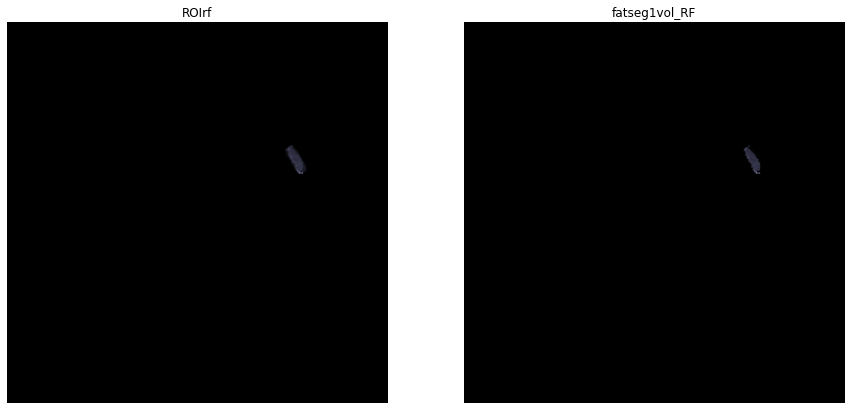

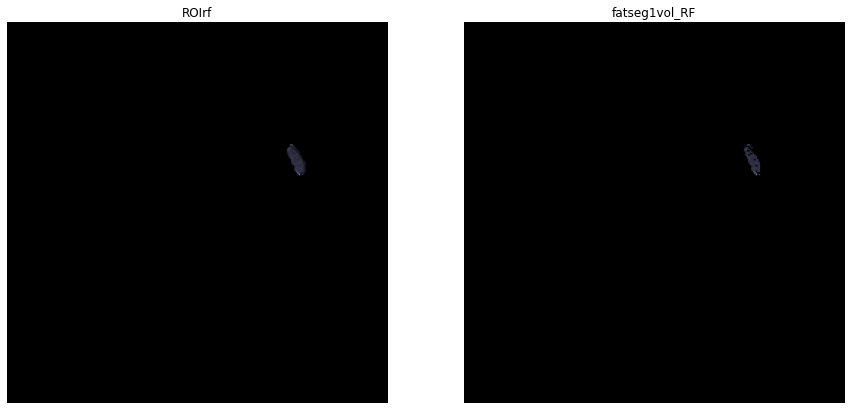

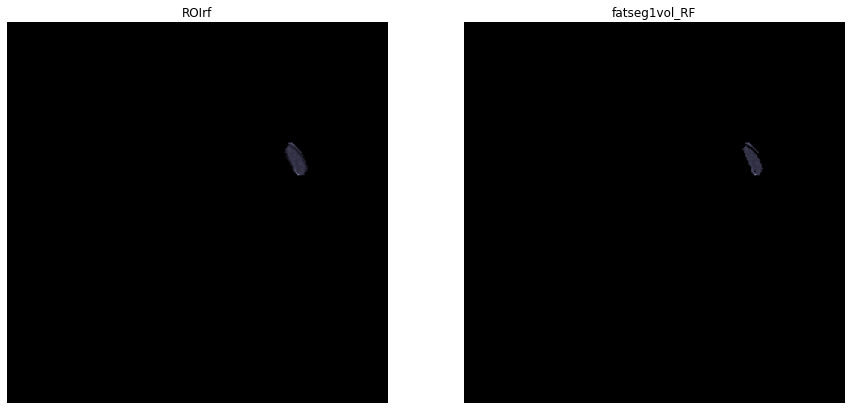

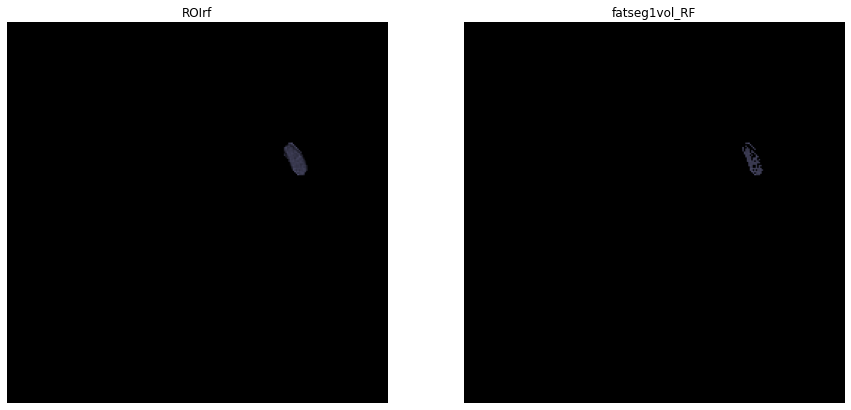

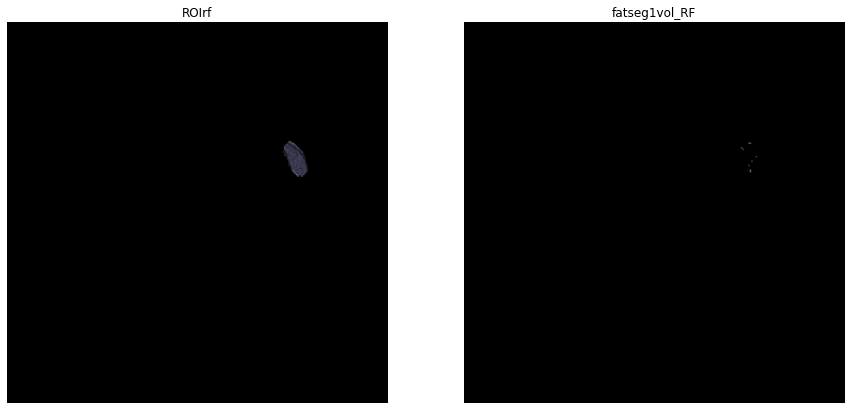

In [600]:
for i in range (5):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIrf[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"ROIrf")
    axs[0].axis("off")
    axs[1].imshow(fatseg1vol_RF[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"fatseg1vol_RF")
    axs[1].axis("off")

In [ ]:
#THIS ONE HAS PROBLEMS

# # ITSA Implementation (VG)

In [ ]:
vg=outputs[: , :, :, 1]
ROIvg=vg*inputs1

In [ ]:
iThreshold_VG=[]
for i in range(j):
    iThreshold_VG.append([])
    iThreshold_VG[i]=multi_otsu(ROIvg[i])

In [ ]:
def ITSA_VG(i, roivar, ots, zcheck):
    k_VG=1
    ThPrev_VG=0 
    ThRev_VG= ots[i] 
    x_VG=0
    y_VG=0
    while ThRev_VG!=ThPrev_VG:
        ThPrev_VG=ThRev_VG
        prefatmask_VG = (ROIvg[i]>ThRev_VG)
        prefatmask_VG = np.uint8(prefatmask_VG)
        ret_VG, fatmask_VG = cv2.threshold(prefatmask_VG,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next_VG=zcheck[i+1]+fatmask_VG
            ret_VG, fatconnectedparts_next_VG= cv2.threshold(fatcombined_next_VG,1,1,cv2.THRESH_BINARY)
            z_connection_VG=fatconnectedparts_next_VG
        elif i==(j-1):
            fatcombined_prev_VG=zcheck[i-1]+fatmask_VG
            ret_VG, fatconnectedparts_prev_VG= cv2.threshold(fatcombined_prev_VG,1,1,cv2.THRESH_BINARY)
            z_connection_VG=fatconnectedparts_prev_VG 
        else:
            fatcombined_prev_VG=zcheck[i-1]+fatmask_VG
            fatcombined_next_VG=fatmask_VG+zcheck[i+1]
            ret_VG, fatconnectedparts_prev_VG= cv2.threshold(fatcombined_prev_VG,1,1,cv2.THRESH_BINARY)
            ret_VG, fatconnectedparts_next_VG= cv2.threshold(fatcombined_next_VG,1,1,cv2.THRESH_BINARY)

            z_connection_VG=fatconnectedparts_prev_VG+fatconnectedparts_next_VG
            ret_VG, z_connection_VG= cv2.threshold(z_connection_VG,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates_VG= np.argwhere(z_connection_VG ==1) #put coordinates of Z-connections into a list      
        im_ff_VG=fatmask_VG.copy()
        h_VG, w_VG = im_ff_VG.shape[:2] #added
        mask_VG = np.zeros((h_VG+2, w_VG+2), np.uint8)
        for item_VG in range(len(coordinates_VG)):
            cv2.floodFill(im_ff_VG, mask_VG, (coordinates_VG[item_VG][1],coordinates_VG[item_VG][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ_VG =label(im_ff_VG==1)
        nonZ_keep_VG = (morphology.remove_small_objects(nonZ_VG,min_size=8, connectivity=1))
        ret_VG, nonZ_keep_VG= cv2.threshold(np.uint8(nonZ_keep_VG),0,1,cv2.THRESH_BINARY)
        Z_VG = (im_ff_VG==2)
        prefatseg1_VG=(Z_VG+nonZ_keep_VG) #do we need int cus boolean??
        fatseg1_VG=prefatseg1_VG*ROIvg[i]
        #Fat and Muscle Quantification
        preMuscSegP_VG=ROIvg[i]-fatseg1_VG
        MuscSegP_VG=np.ma.masked_where(preMuscSegP_VG == 0, preMuscSegP_VG)
        FatSegP_VG=np.ma.masked_where(fatseg1_VG==0,fatseg1_VG) 
        MuscSegI_VG=np.mean(MuscSegP_VG)
        FatSegI_VG=np.mean(FatSegP_VG)
        ThRev_VG=(1+((FatSegI_VG-MuscSegI_VG)/FatSegI_VG))*MuscSegI_VG
        print (f"Slice #{i+1} Iteration={k_VG}\n\tThPrev={ThPrev_VG}\n\tThRev={ThRev_VG}\n")

        k_VG+=1
        if k_VG==50:
            break

    thresholds_VG=ThRev_VG
    return prefatseg1_VG, fatseg1_VG, thresholds_VG

In [ ]:
fatseg1vol_mask_VG=np.zeros([vg.shape[0], vg.shape[1], vg.shape[2]], dtype='uint8')
fatseg1vol_VG=np.zeros([vg.shape[0], vg.shape[1], vg.shape[2]], dtype='uint8') #change name

thresholds_VG=[] #change name compared to single slice?
for i in range(j):
    thresholds_VG.append([])
    fatseg1vol_mask_VG[i],fatseg1vol_VG[i], thresholds_VG[i]=ITSA_VG(i,ROIvg,iThreshold_VG,vg)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Th1 R2= {iThreshold_VG[i]}")
    print ("-----------------------------------------------------------")

for i in range(j):
    print (f"Slice #{i+1} Th1 R2 OG/Rev={iThreshold_VG[i]}")

In [ ]:
for i in range (5):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIvg[i],"bone",)
    axs[0].set_title(f"ROIvg")
    axs[0].axis("off")
    axs[1].imshow(fatseg1vol_VG[i],"bone")
    axs[1].set_title(f"fatseg1vol_VG")
    axs[1].axis("off")

In [ ]:
vgR1=ROIvg-fatseg1vol_VG
for i in range (j):
    plt.imshow(vgR1[i],cmap=plt.cm.bone)
    plt.imshow(fatseg1vol_VG[i],cmap=plt.cm.bone,alpha=0.5)
    plt.show()

# # ITSA Implementation (AD)

In [538]:
ad=outputs[: , :, :, 5]
ROIad=ad*inputs1

[26.84960938 90.56054688]
Slice 1 otsu threshold=90.560546875
[23.73046875 74.12109375]
Slice 2 otsu threshold=74.12109375
[28.04492188 86.83789062]
Slice 3 otsu threshold=86.837890625
[ 32.78515625 106.87109375]
Slice 4 otsu threshold=106.87109375
[ 31.93945312 122.66601562]
Slice 5 otsu threshold=122.666015625


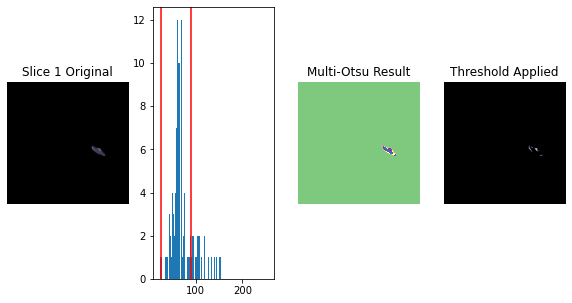

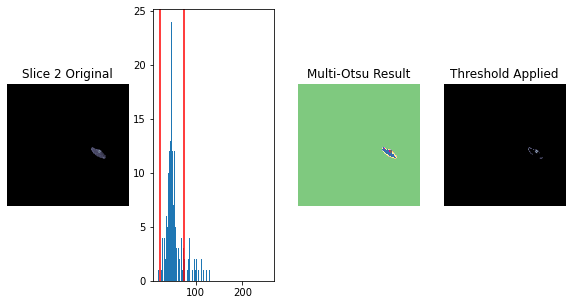

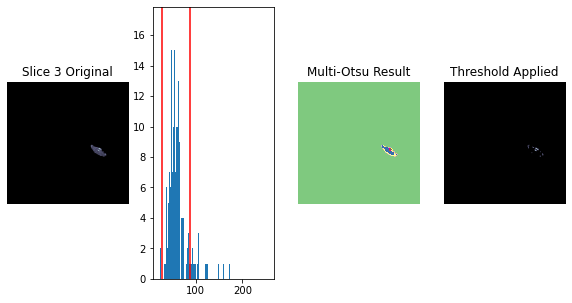

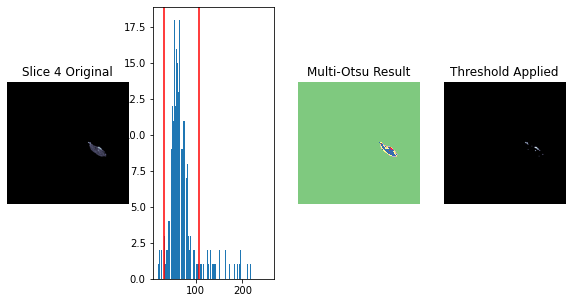

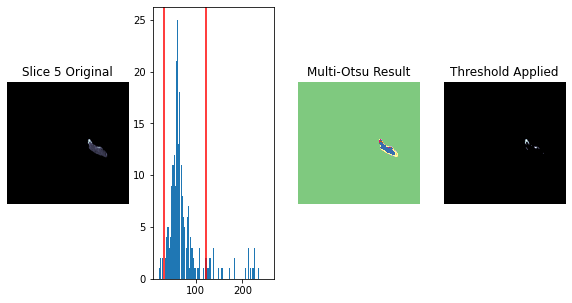

In [539]:
iThreshold_ad=[]
for i in range(j):
    iThreshold_ad.append([])
    iThreshold_ad[i]=multi_otsu(ROIad[i])

In [593]:
def ITSA_ad(i, roivar, ots, zcheck):
    k_ad=1
    ThPrev_ad=0 
    ThRev_ad= ots[i] 
    x_ad=0
    y_ad=0
    while ThRev_ad!=ThPrev_ad:
        ThPrev_ad=ThRev_ad
        prefatmask_ad = (ROIad[i]>ThRev_ad)
        prefatmask_ad = np.uint8(prefatmask_ad)
        ret_ad, fatmask_ad = cv2.threshold(prefatmask_ad,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next_ad=zcheck[i+1]+fatmask_ad
            ret_ad, fatconnectedparts_next_ad= cv2.threshold(fatcombined_next_ad,1,1,cv2.THRESH_BINARY)
            z_connection_ad=fatconnectedparts_next_ad
        elif i==(j-1):
            fatcombined_prev_ad=zcheck[i-1]+fatmask_ad
            ret_ad, fatconnectedparts_prev_ad= cv2.threshold(fatcombined_prev_ad,1,1,cv2.THRESH_BINARY)
            z_connection_ad=fatconnectedparts_prev_ad  
        else:
            fatcombined_prev_ad=zcheck[i-1]+fatmask_ad
            fatcombined_next_ad=fatmask_ad+zcheck[i+1]
            ret_ad, fatconnectedparts_prev_ad= cv2.threshold(fatcombined_prev_ad,1,1,cv2.THRESH_BINARY)
            ret_ad, fatconnectedparts_next_ad= cv2.threshold(fatcombined_next_ad,1,1,cv2.THRESH_BINARY)

            z_connection_ad=fatconnectedparts_prev_ad+fatconnectedparts_next_ad
            ret_ad, z_connection_ad= cv2.threshold(z_connection_ad,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates_ad= np.argwhere(z_connection_ad ==1) #put coordinates of Z-connections into a list      
        im_ff_ad=fatmask_ad.copy()
        h_ad, w_ad = im_ff_ad.shape[:2] #added
        mask_ad = np.zeros((h_ad+2, w_ad+2), np.uint8)
        for item in range(len(coordinates_ad)):
            cv2.floodFill(im_ff_ad, mask_ad, (coordinates_ad[item][1],coordinates_ad[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ_ad =label(im_ff_ad==1)
        nonZ_keep_ad = (morphology.remove_small_objects(nonZ_ad,min_size=8, connectivity=1))
        ret_ad, nonZ_keep_ad= cv2.threshold(np.uint8(nonZ_keep_ad),0,1,cv2.THRESH_BINARY)
        Z_ad = (im_ff_ad==2)
        prefatseg1_ad=(Z_ad+nonZ_keep_ad) #do we need int cus boolean??
        fatseg1_ad=prefatseg1_ad*ROIad[i]
        #Fat and Muscle Quantification
        preMuscSegP_ad=ROIad[i]-fatseg1_ad
        MuscSegP_ad=np.ma.masked_where(preMuscSegP_ad == 0, preMuscSegP_ad)
        FatSegP_ad=np.ma.masked_where(fatseg1_ad==0,fatseg1_ad) 
        MuscSegI_ad=np.mean(MuscSegP_ad)
        FatSegI_ad=np.mean(FatSegP_ad)
        ThRev_ad=(1+((FatSegI_ad-MuscSegI_ad)/FatSegI_ad))*MuscSegI_ad
        print (f"Slice #{i+1} Iteration={k_ad}\n\tThPrev={ThPrev_ad}\n\tThRev={ThRev_ad}\n")

        k_ad+=1
        if k_ad==50:
            break

    thresholds_ad=ThRev_ad
    return prefatseg1_ad, fatseg1_ad, thresholds_ad

In [594]:
fatseg1vol_mask_ad=np.zeros([ad.shape[0], ad.shape[1], ad.shape[2]], dtype='uint8')
fatseg1vol_ad=np.zeros([ad.shape[0], ad.shape[1], ad.shape[2]], dtype='uint8') #change name
threshold_R1_ad=[] #change name compared to single slice?
for i in range(j):
    threshold_R1_ad.append([])
    fatseg1vol_mask_ad[i],fatseg1vol_ad[i], threshold_R1_ad[i]=ITSA_ad(i, ROIad,iThreshold_ad,ad)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Th1 = {threshold_R1_ad[i]}")
    print ("-----------------------------------------------------------")

for i in range(j):
    print (f"Slice #{i+1} Th1 OG/Rev={threshold_R1_ad[i]}")

Slice #1 Iteration=1
	ThPrev=90.560546875
	ThRev=92.21068321044403

Slice #1 Iteration=2
	ThPrev=92.21068321044403
	ThRev=92.82787334042513

Slice #1 Iteration=3
	ThPrev=92.82787334042513
	ThRev=92.82787334042513

Slice #1 Th1 = 92.82787334042513
-----------------------------------------------------------
Slice #2 Iteration=1
	ThPrev=74.12109375
	ThRev=73.3582414833485

Slice #2 Iteration=2
	ThPrev=73.3582414833485
	ThRev=72.70594141041808

Slice #2 Iteration=3
	ThPrev=72.70594141041808
	ThRev=72.08456211103426

Slice #2 Iteration=4
	ThPrev=72.08456211103426
	ThRev=72.08456211103426

Slice #2 Th1 = 72.08456211103426
-----------------------------------------------------------
Slice #3 Iteration=1
	ThPrev=86.837890625
	ThRev=84.47913599543276

Slice #3 Iteration=2
	ThPrev=84.47913599543276
	ThRev=83.12206017492494

Slice #3 Iteration=3
	ThPrev=83.12206017492494
	ThRev=82.61721337523747

Slice #3 Iteration=4
	ThPrev=82.61721337523747
	ThRev=82.61721337523747

Slice #3 Th1 = 82.61721337523

<ipython-input-593-0a074713d19b>:37: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nonZ_keep_ad = (morphology.remove_small_objects(nonZ_ad,min_size=8, connectivity=1))


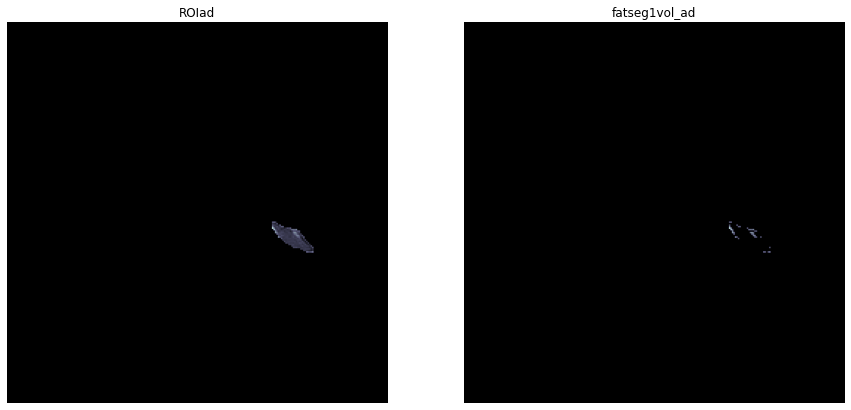

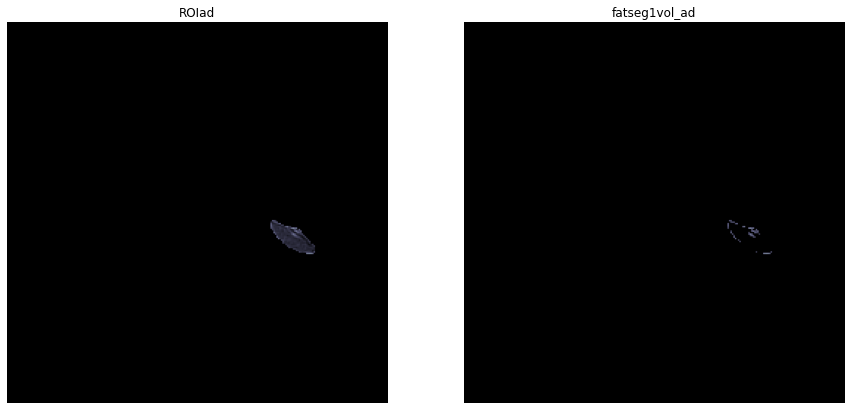

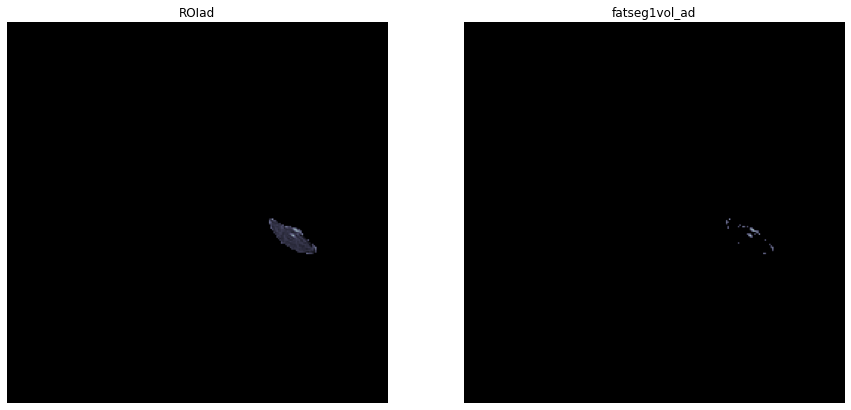

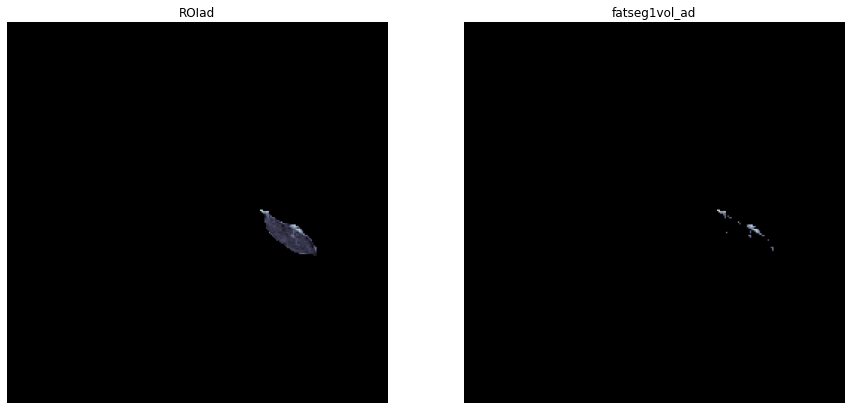

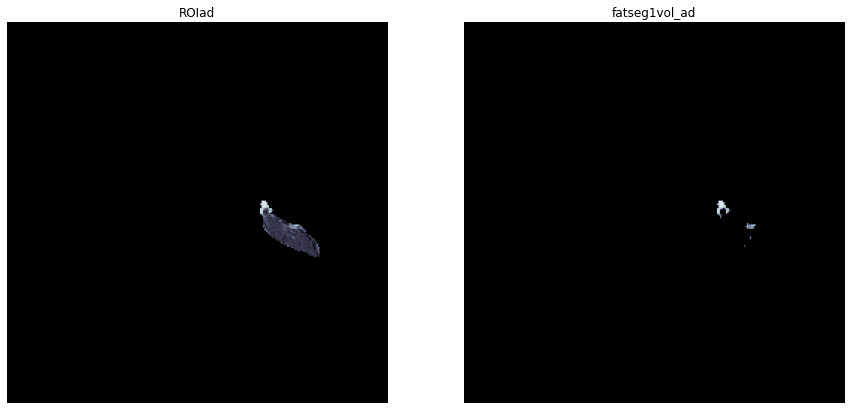

In [601]:
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIad[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"ROIad")
    axs[0].axis("off")
    axs[1].imshow(fatseg1vol_ad[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"fatseg1vol_ad")
    axs[1].axis("off")

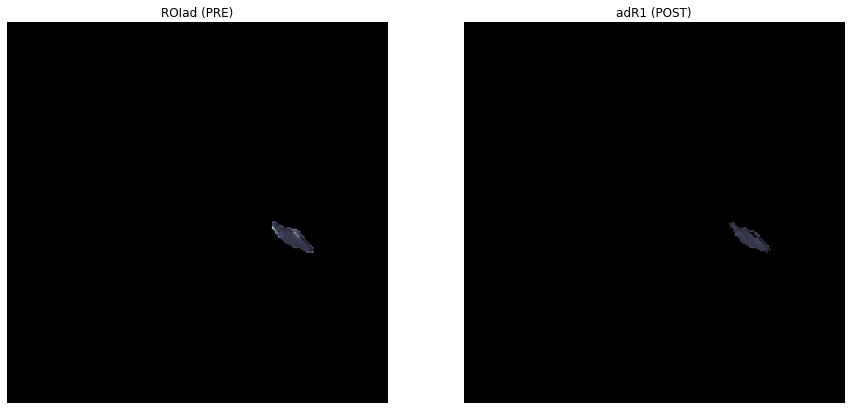

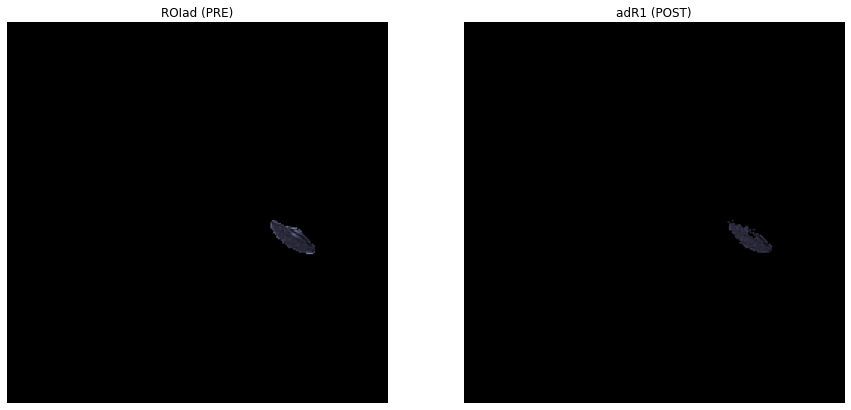

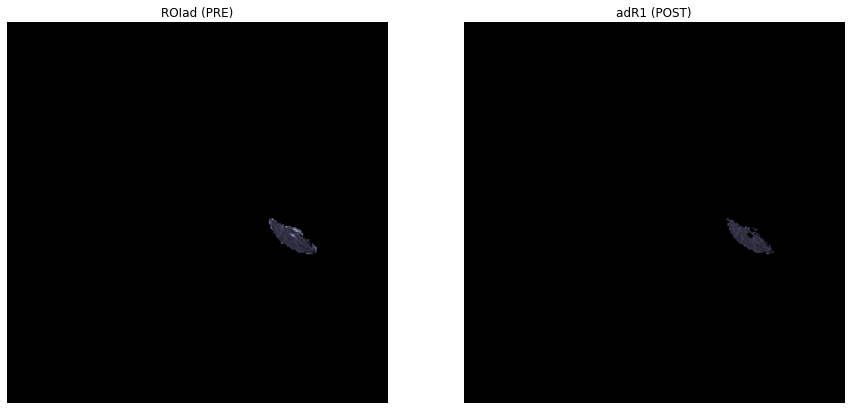

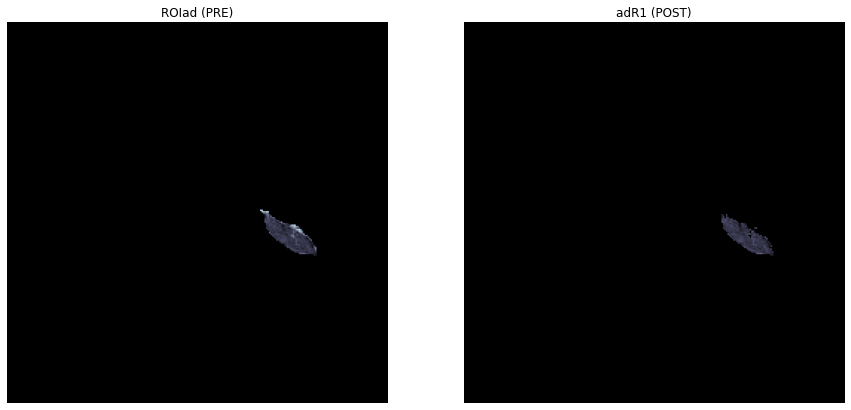

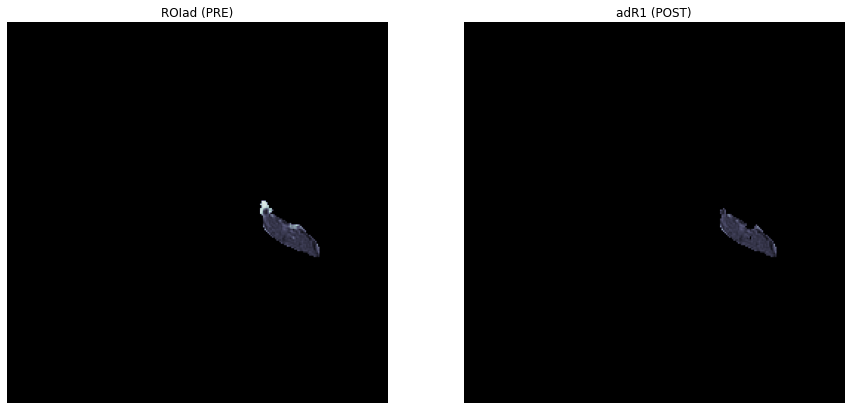

In [599]:
adR1=ROIad-fatseg1vol_ad
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIad[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"ROIad (PRE)")
    axs[0].axis("off")
    axs[1].imshow(adR1[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"adR1 (POST)")
    axs[1].axis("off")

# # ITSA Implementation (SR)

In [533]:
sr=outputs[: , :, :, 4]
ROIsr=sr*inputs1

[ 32.65039062 100.63476562]
Slice 1 otsu threshold=100.634765625
[24.0703125 70.9921875]
Slice 2 otsu threshold=70.9921875
[26.10351562 75.73242188]
Slice 3 otsu threshold=75.732421875
[33.36914062 97.75195312]
Slice 4 otsu threshold=97.751953125
[31.9375 86.1875]
Slice 5 otsu threshold=86.1875


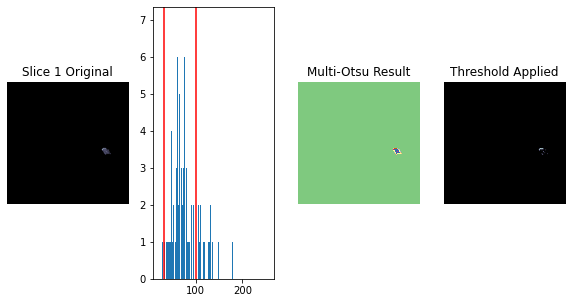

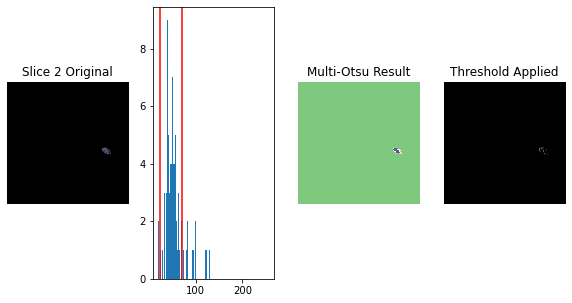

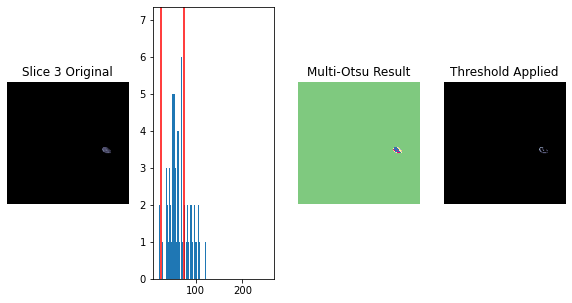

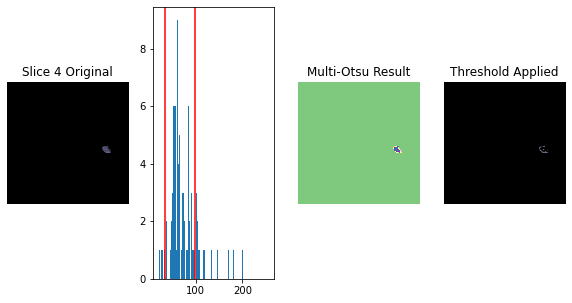

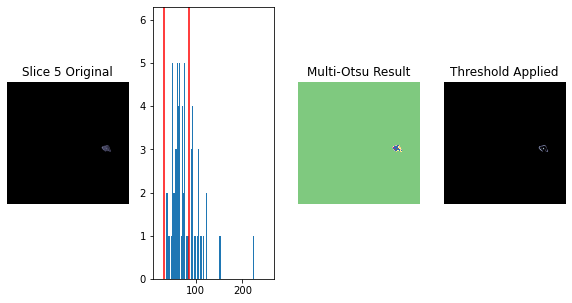

In [540]:
iThreshold_sr=[]
for i in range(j):
    iThreshold_sr.append([])
    iThreshold_sr[i]=multi_otsu(ROIsr[i])

In [661]:
def ITSA_sr(i, roivar, ots, zcheck):
    k_sr=1
    ThPrev_sr=0 
    ThRev_sr= ots[i] 
    x_sr=0
    y_sr=0
    while ThRev_sr!=ThPrev_sr:
        ThPrev_sr=ThRev_sr
        prefatmask_sr = (ROIsr[i]>ThRev_sr)
        prefatmask_sr = np.uint8(prefatmask_sr)
        ret_sr, fatmask_sr = cv2.threshold(prefatmask_sr,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next_sr=zcheck[i+1]+fatmask_sr
            ret_sr, fatconnectedparts_next_sr= cv2.threshold(fatcombined_next_sr,1,1,cv2.THRESH_BINARY)
            z_connection_sr=fatconnectedparts_next_sr
        elif i==(j-1):
            fatcombined_prev_sr=zcheck[i-1]+fatmask_sr
            ret_sr, fatconnectedparts_prev_sr= cv2.threshold(fatcombined_prev_sr,1,1,cv2.THRESH_BINARY)
            z_connection_sr=fatconnectedparts_prev_sr  
        else:
            fatcombined_prev_sr=zcheck[i-1]+fatmask_sr
            fatcombined_next_sr=fatmask_sr+zcheck[i+1]
            ret_sr, fatconnectedparts_prev_sr= cv2.threshold(fatcombined_prev_sr,1,1,cv2.THRESH_BINARY)
            ret_sr, fatconnectedparts_next_sr= cv2.threshold(fatcombined_next_sr,1,1,cv2.THRESH_BINARY)

            z_connection_sr=fatconnectedparts_prev_sr+fatconnectedparts_next_sr
            ret_sr, z_connection_sr= cv2.threshold(z_connection_sr,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates_sr= np.argwhere(z_connection_sr ==1) #put coordinates of Z-connections into a list      
        im_ff_sr=fatmask_sr.copy()
        h_sr, w_sr = im_ff_sr.shape[:2] #added
        mask_sr = np.zeros((h_sr+2, w_sr+2), np.uint8)
        for item in range(len(coordinates_sr)):
            cv2.floodFill(im_ff_sr, mask_sr, (coordinates_sr[item][1],coordinates_sr[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ_sr =label(im_ff_sr==1)
        nonZ_keep_sr = (morphology.remove_small_objects(nonZ_sr,min_size=8, connectivity=1))
        ret_sr, nonZ_keep_sr= cv2.threshold(np.uint8(nonZ_keep_sr),0,1,cv2.THRESH_BINARY)
        Z_sr = (im_ff_sr==2)
        prefatseg1_sr=(Z_sr+nonZ_keep_sr) #do we need int cus boolean??
        fatseg1_sr=prefatseg1_sr*ROIsr[i]
        #Fat and Muscle Quantification
        preMuscSegP_sr=ROIsr[i]-fatseg1_sr
        MuscSegP_sr=np.ma.masked_where(preMuscSegP_sr == 0, preMuscSegP_sr)
        FatSegP_sr=np.ma.masked_where(fatseg1_sr==0,fatseg1_sr) 
        MuscSegI_sr=np.mean(MuscSegP_sr)
        FatSegI_sr=np.mean(FatSegP_sr)
        ThRev_sr=(1+((FatSegI_sr-MuscSegI_sr)/FatSegI_sr))*MuscSegI_sr
        print (f"Slice #{i+1} Iteration={k_sr}\n\tThPrev={ThPrev_sr}\n\tThRev={ThRev_sr}\n")

        k_sr+=1
        if k_sr==50:
            break

    thresholds_sr=ThRev_sr
    return prefatseg1_sr, fatseg1_sr, thresholds_sr

In [662]:
fatseg1vol_mask_sr=np.zeros([sr.shape[0], inputs1.shape[1], inputs1.shape[2]], dtype='uint8')
fatseg1vol_sr=np.zeros([inputs1.shape[0], inputs1.shape[1], inputs1.shape[2]], dtype='uint8') #change name
threshold_R1_sr=[] #change name compared to single slice?
for i in range(j):
    threshold_R1_sr.append([])
    fatseg1vol_mask_sr[i],fatseg1vol_sr[i], threshold_R1_sr[i]=ITSA_sr(i, ROIsr,iThreshold_sr,sr)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Th1 = {threshold_R1_sr[i]}")
    print ("-----------------------------------------------------------")

for i in range(j):
    print (f"Slice #{i+1} Th1 OG/Rev={threshold_R1_sr[i]}")

Slice #1 Iteration=1
	ThPrev=100.634765625
	ThRev=100.26066626764468

Slice #1 Iteration=2
	ThPrev=100.26066626764468
	ThRev=100.26066626764468

Slice #1 Th1 = 100.26066626764468
-----------------------------------------------------------
Slice #2 Iteration=1
	ThPrev=70.9921875
	ThRev=71.27189782825319

Slice #2 Iteration=2
	ThPrev=71.27189782825319
	ThRev=71.7065758775806

Slice #2 Iteration=3
	ThPrev=71.7065758775806
	ThRev=71.7065758775806

Slice #2 Th1 = 71.7065758775806
-----------------------------------------------------------
Slice #3 Iteration=1
	ThPrev=75.732421875
	ThRev=76.09354746048406

Slice #3 Iteration=2
	ThPrev=76.09354746048406
	ThRev=76.80804724233984

Slice #3 Iteration=3
	ThPrev=76.80804724233984
	ThRev=76.80804724233984

Slice #3 Th1 = 76.80804724233984
-----------------------------------------------------------
Slice #4 Iteration=1
	ThPrev=97.751953125
	ThRev=95.06552903697515

Slice #4 Iteration=2
	ThPrev=95.06552903697515
	ThRev=94.15085381323769

Slice #4 Ite

<ipython-input-661-2a4e97fb4e96>:37: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nonZ_keep_sr = (morphology.remove_small_objects(nonZ_sr,min_size=8, connectivity=1))


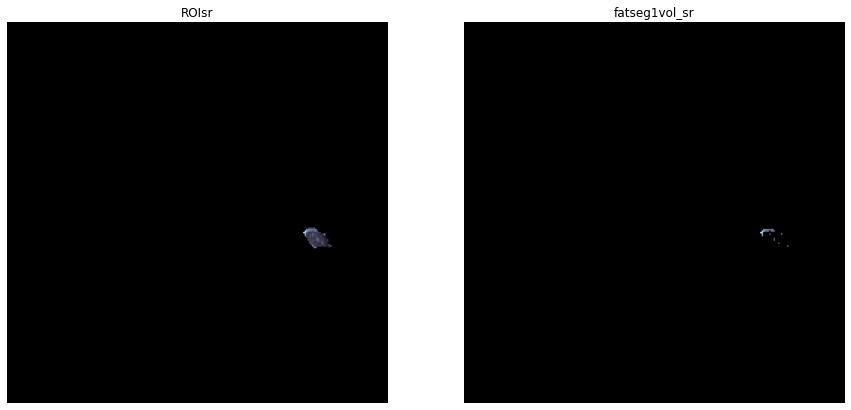

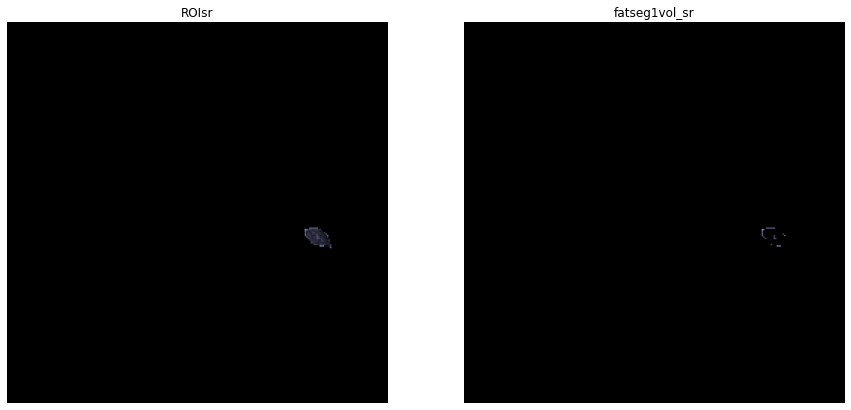

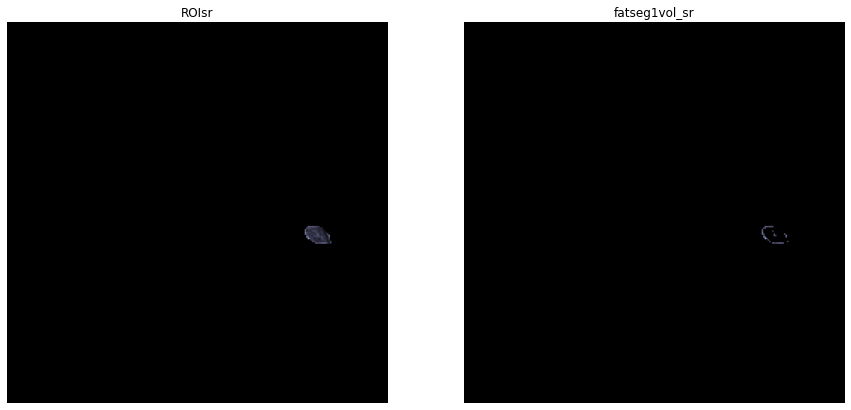

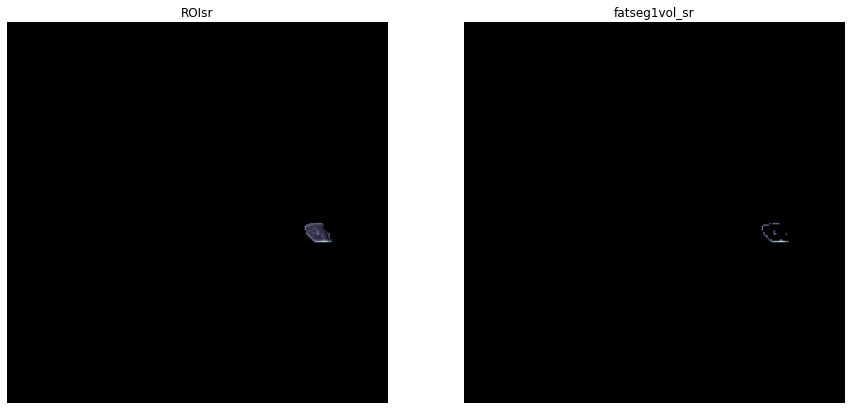

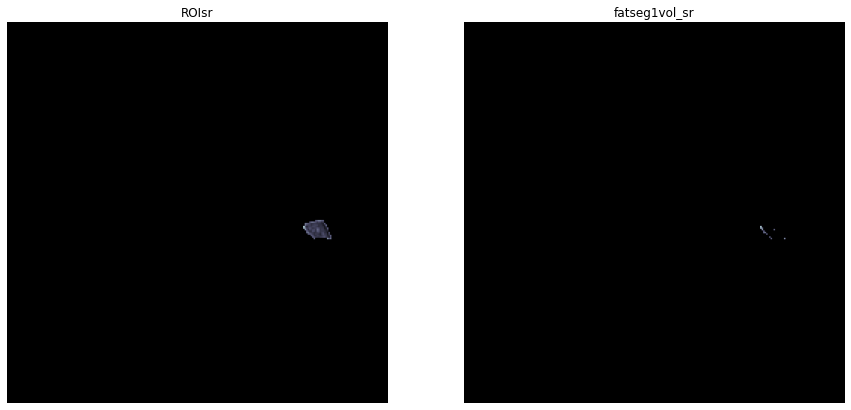

In [667]:
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIsr[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"ROIsr")
    axs[0].axis("off")
    axs[1].imshow(fatseg1vol_sr[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"fatseg1vol_sr")
    axs[1].axis("off")

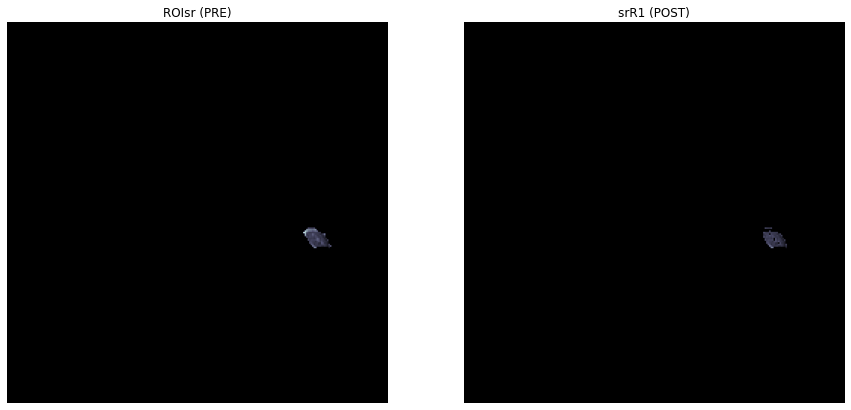

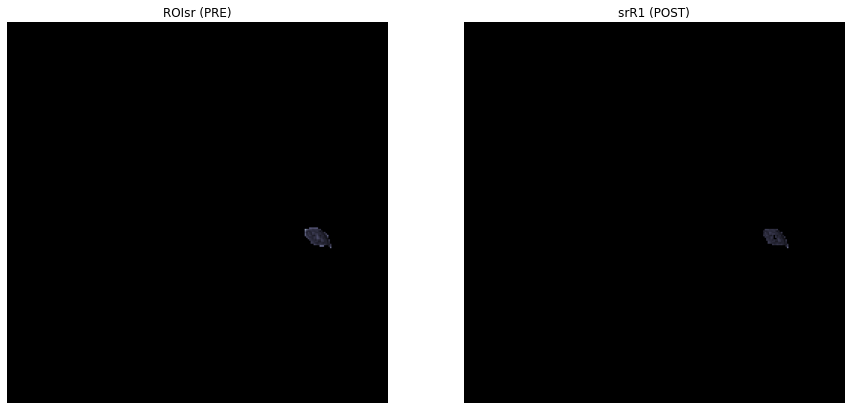

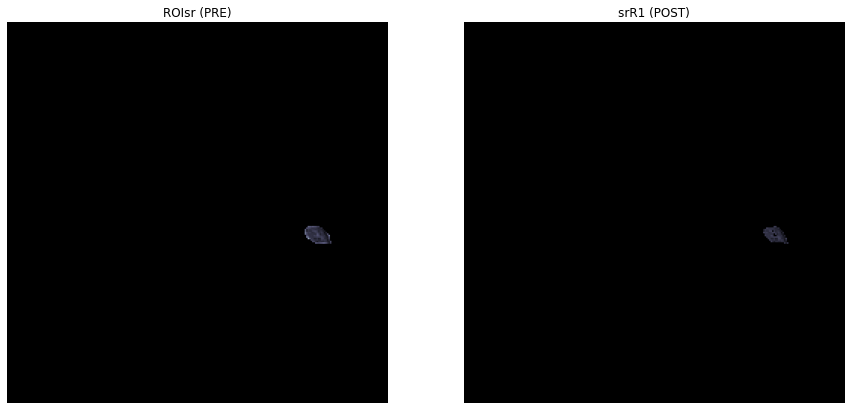

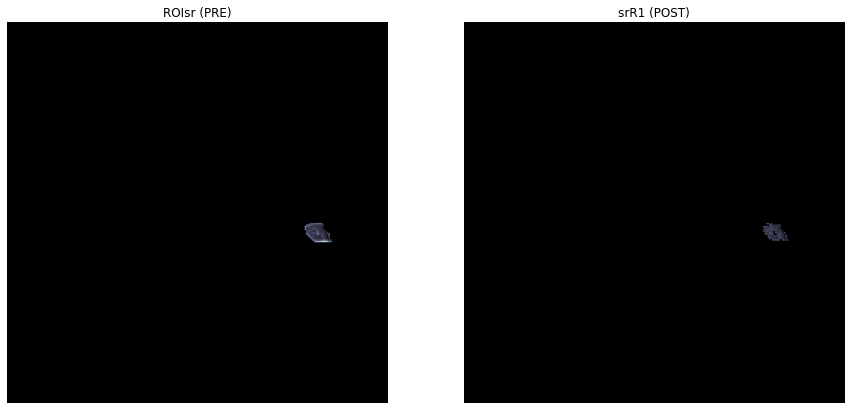

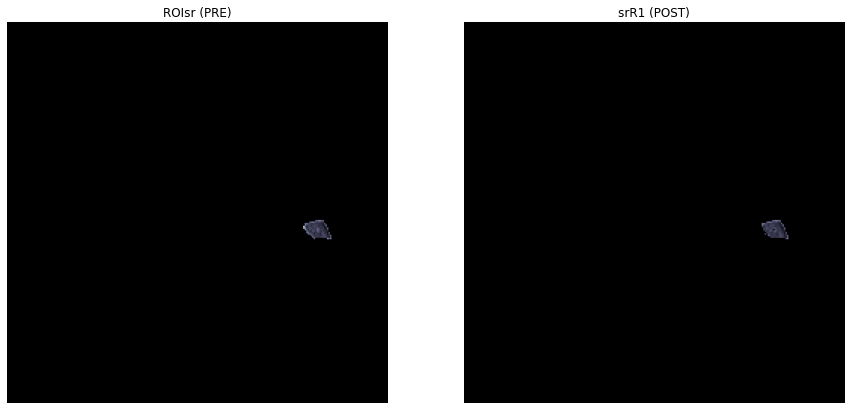

In [666]:
srR1=ROIsr-fatseg1vol_sr
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIsr[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"ROIsr (PRE)")
    axs[0].axis("off")
    axs[1].imshow(srR1[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"srR1 (POST)")
    axs[1].axis("off")

# # ITSA Implementation (GR)

In [534]:
gr=outputs[: , :, :, 3]
ROIgr=gr*inputs1

[ 29.65625 100.34375]
Slice 1 otsu threshold=100.34375
[19.13671875 69.80859375]
Slice 2 otsu threshold=69.80859375
[21.078125 67.984375]
Slice 3 otsu threshold=67.984375
[26.66015625 87.08984375]
Slice 4 otsu threshold=87.08984375
[26.91015625 82.02734375]
Slice 5 otsu threshold=82.02734375


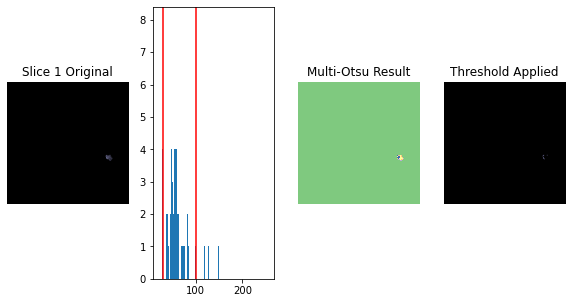

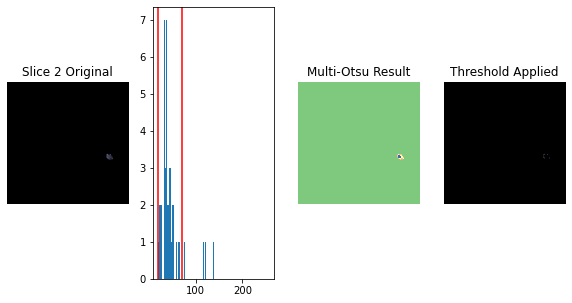

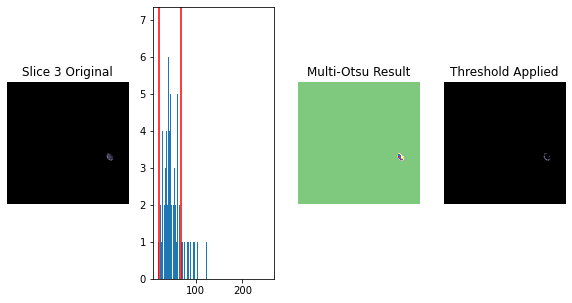

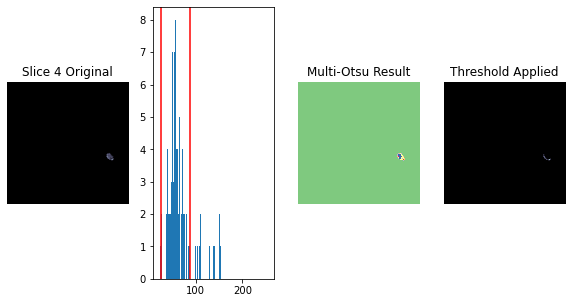

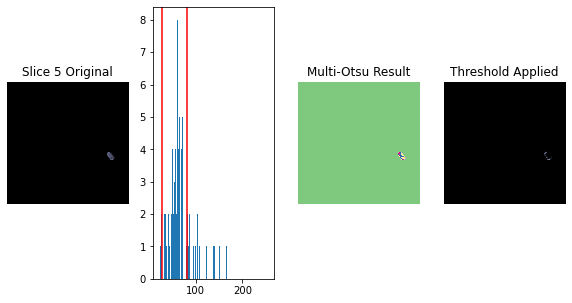

In [541]:
iThreshold_gr=[]
for i in range(j):
    iThreshold_gr.append([])
    iThreshold_gr[i]=multi_otsu(ROIgr[i])

In [668]:
def ITSA_gr(i, roivar, ots, zcheck):
    k_gr=1
    ThPrev_gr=0 
    ThRev_gr= ots[i] 
    x_gr=0
    y_gr=0
    while ThRev_gr!=ThPrev_gr:
        ThPrev_gr=ThRev_gr
        prefatmask_gr = (ROIgr[i]>ThRev_gr)
        prefatmask_gr = np.uint8(prefatmask_gr)
        ret_gr, fatmask_gr = cv2.threshold(prefatmask_gr,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next_gr=zcheck[i+1]+fatmask_gr
            ret_gr, fatconnectedparts_next_gr= cv2.threshold(fatcombined_next_gr,1,1,cv2.THRESH_BINARY)
            z_connection_gr=fatconnectedparts_next_gr
        elif i==(j-1):
            fatcombined_prev_gr=zcheck[i-1]+fatmask_gr
            ret_gr, fatconnectedparts_prev_gr= cv2.threshold(fatcombined_prev_gr,1,1,cv2.THRESH_BINARY)
            z_connection_gr=fatconnectedparts_prev_gr
        else:
            fatcombined_prev_gr=zcheck[i-1]+fatmask_gr
            fatcombined_next_gr=fatmask_gr+zcheck[i+1]
            ret_gr, fatconnectedparts_prev_gr= cv2.threshold(fatcombined_prev_gr,1,1,cv2.THRESH_BINARY)
            ret_gr, fatconnectedparts_next_gr= cv2.threshold(fatcombined_next_gr,1,1,cv2.THRESH_BINARY)

            z_connection_gr=fatconnectedparts_prev_gr+fatconnectedparts_next_gr
            ret_gr, z_connection_gr= cv2.threshold(z_connection_gr,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates_gr= np.argwhere(z_connection_gr ==1) #put coordinates of Z-connections into a list      
        im_ff_gr=fatmask_gr.copy()
        h_gr, w_gr = im_ff_gr.shape[:2] #added
        mask_gr = np.zeros((h_gr+2, w_gr+2), np.uint8)
        for item in range(len(coordinates_gr)):
            cv2.floodFill(im_ff_gr, mask_gr, (coordinates_gr[item][1],coordinates_gr[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ_gr =label(im_ff_gr==1)
        nonZ_keep_gr = (morphology.remove_small_objects(nonZ_gr,min_size=8, connectivity=1))
        ret_gr, nonZ_keep_gr= cv2.threshold(np.uint8(nonZ_keep_gr),0,1,cv2.THRESH_BINARY)
        Z_gr = (im_ff_gr==2)
        prefatseg1_gr=(Z_gr+nonZ_keep_gr) #do we need int cus boolean??
        fatseg1_gr=prefatseg1_gr*ROIgr[i]
        #Fat and Muscle Quantification
        preMuscSegP_gr=ROIgr[i]-fatseg1_gr
        MuscSegP_gr=np.ma.masked_where(preMuscSegP_gr == 0, preMuscSegP_gr)
        FatSegP_gr=np.ma.masked_where(fatseg1_gr==0,fatseg1_gr) 
        MuscSegI_gr=np.mean(MuscSegP_gr)
        FatSegI_gr=np.mean(FatSegP_gr)
        ThRev_gr=(1+((FatSegI_gr-MuscSegI_gr)/FatSegI_gr))*MuscSegI_gr
        print (f"Slice #{i+1} Iteration={k_gr}\n\tThPrev={ThPrev_gr}\n\tThRev={ThRev_gr}\n")

        k_gr+=1
        if k_gr==50:
            break

    thresholds_gr=ThRev_gr
    return prefatseg1_gr, fatseg1_gr, thresholds_gr

In [673]:
fatseg1vol_mask_gr=np.zeros([gr.shape[0], gr.shape[1], gr.shape[2]], dtype='uint8')
fatseg1vol_gr=np.zeros([gr.shape[0], gr.shape[1], gr.shape[2]], dtype='uint8') #change name
threshold_R1_gr=[] #change name compared to single slice?
for i in range(j):
    threshold_R1_gr.append([])
    fatseg1vol_mask_gr[i],fatseg1vol_gr[i], threshold_R1_gr[i]=ITSA_gr(i, ROIgr,iThreshold_gr,gr)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Th1 = {threshold_R1_gr[i]}")
    print ("-----------------------------------------------------------")

for i in range(j):
    print (f"Slice #{i+1} Th1 OG/Rev={threshold_R1_gr[i]}")

Slice #1 Iteration=1
	ThPrev=100.34375
	ThRev=92.36460236731668

Slice #1 Iteration=2
	ThPrev=92.36460236731668
	ThRev=92.36460236731668

Slice #1 Th1 = 92.36460236731668
-----------------------------------------------------------
Slice #2 Iteration=1
	ThPrev=69.80859375
	ThRev=60.56140609863527

Slice #2 Iteration=2
	ThPrev=60.56140609863527
	ThRev=56.847713815789476

Slice #2 Iteration=3
	ThPrev=56.847713815789476
	ThRev=53.93102531199511

Slice #2 Iteration=4
	ThPrev=53.93102531199511
	ThRev=52.95753416241076

Slice #2 Iteration=5
	ThPrev=52.95753416241076
	ThRev=52.0643602286792

Slice #2 Iteration=6
	ThPrev=52.0643602286792
	ThRev=52.0643602286792

Slice #2 Th1 = 52.0643602286792
-----------------------------------------------------------
Slice #3 Iteration=1
	ThPrev=67.984375
	ThRev=64.13982816994088

Slice #3 Iteration=2
	ThPrev=64.13982816994088
	ThRev=63.25421355328428

Slice #3 Iteration=3
	ThPrev=63.25421355328428
	ThRev=62.41429944262926

Slice #3 Iteration=4
	ThPrev=62.414

<ipython-input-668-350bfe0567df>:37: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nonZ_keep_gr = (morphology.remove_small_objects(nonZ_gr,min_size=8, connectivity=1))


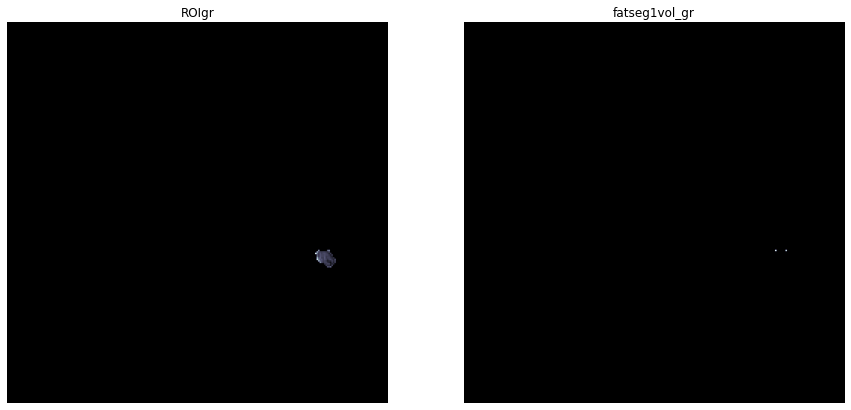

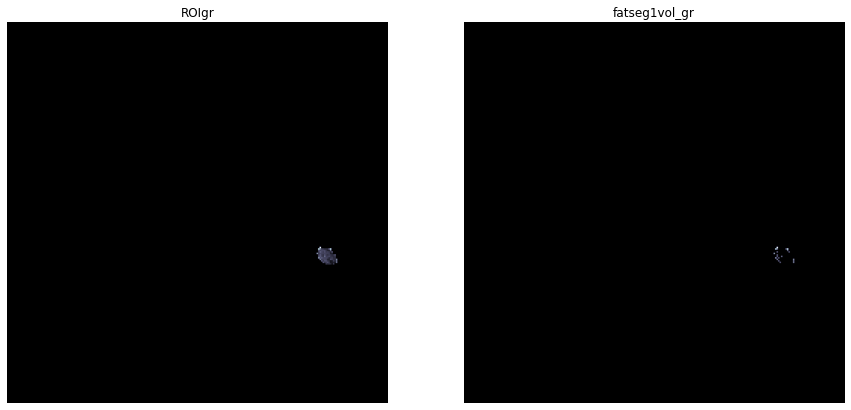

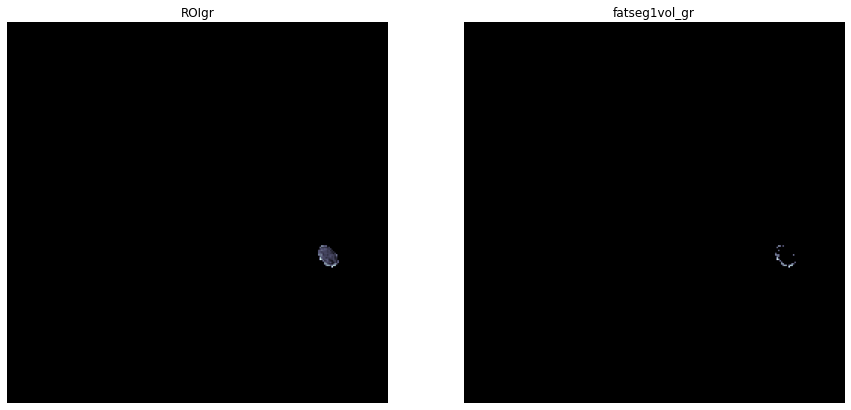

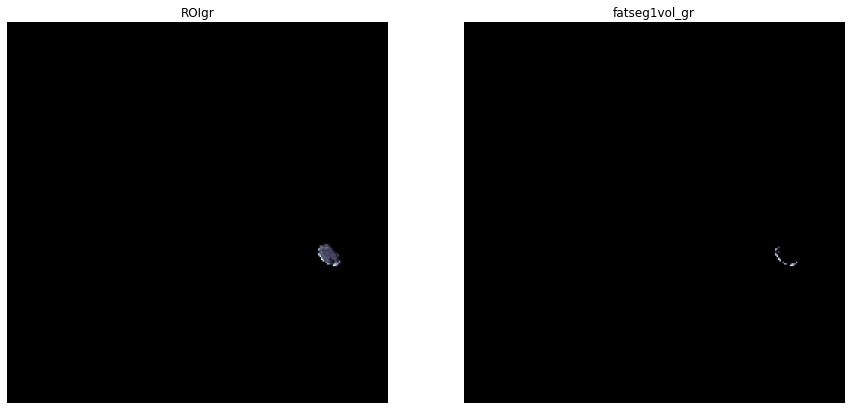

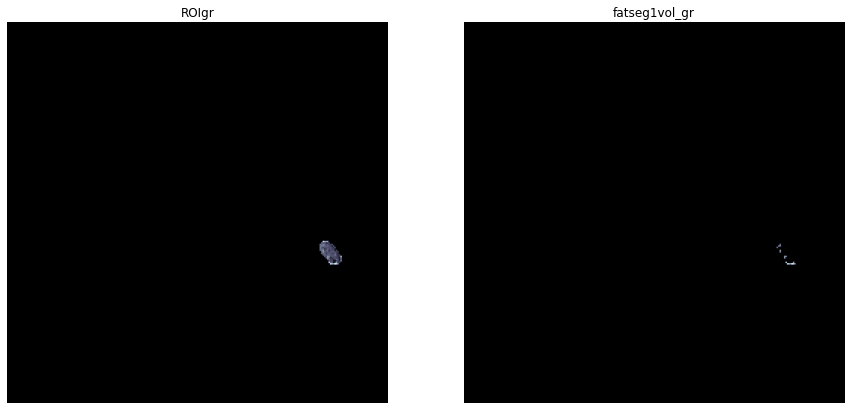

In [674]:
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIgr[i],"bone")
    axs[0].set_title(f"ROIgr")
    axs[0].axis("off")
    axs[1].imshow(fatseg1vol_gr[i],"bone")
    axs[1].set_title(f"fatseg1vol_gr")
    axs[1].axis("off")

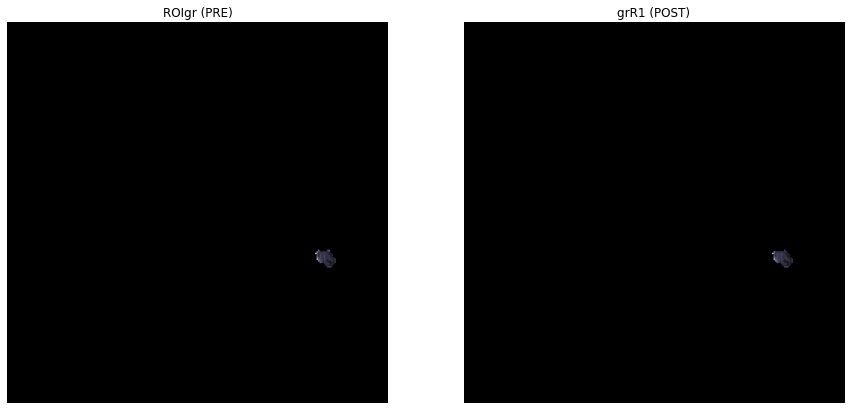

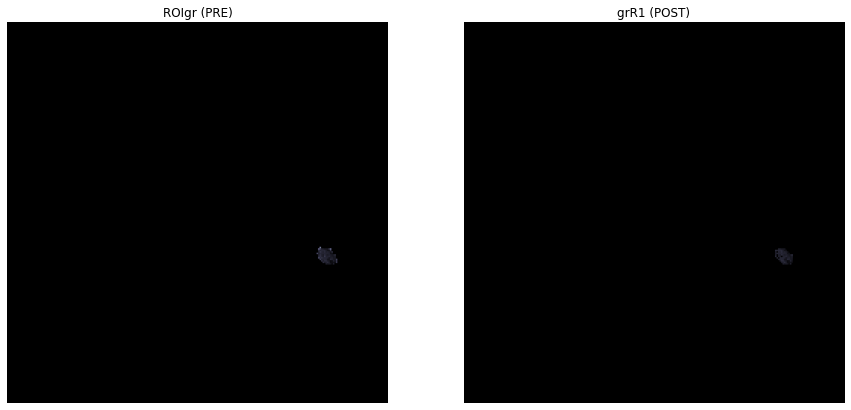

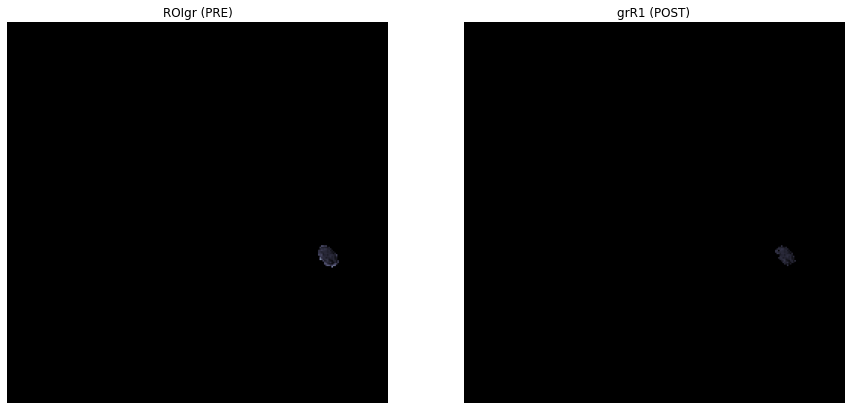

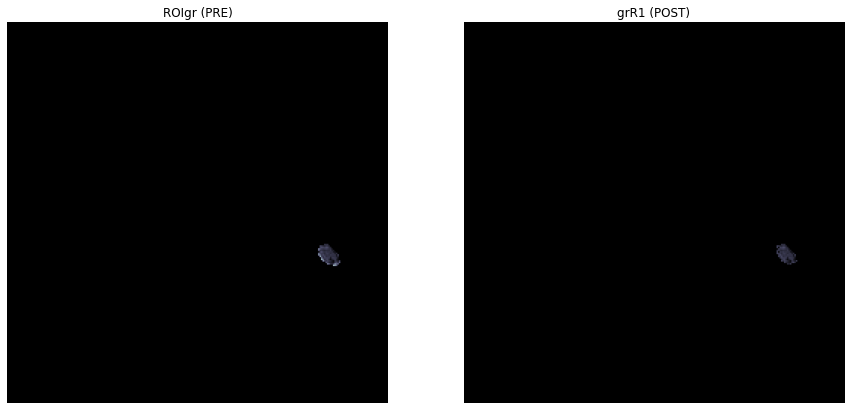

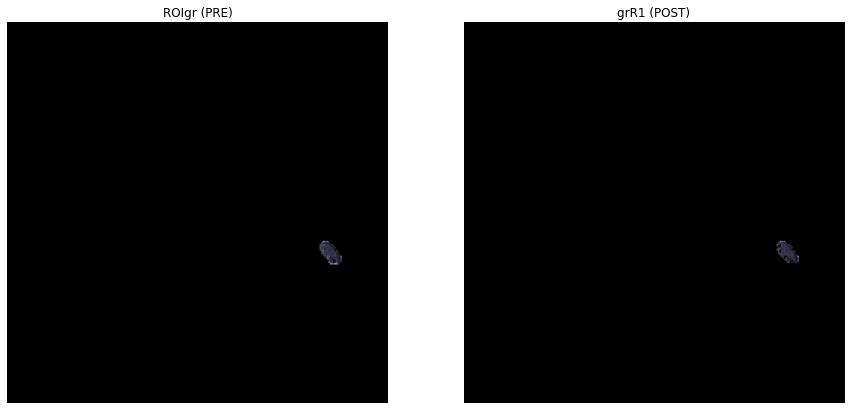

In [676]:
grR1=ROIgr-fatseg1vol_gr
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIgr[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"ROIgr (PRE)")
    axs[0].axis("off")
    axs[1].imshow(grR1[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"grR1 (POST)")
    axs[1].axis("off")

# # ITSA Implementation (BF)

In [535]:
bf=outputs[: , :, :, 6]
ROIbf=bf*inputs1

[31.828125 92.859375]
Slice 1 otsu threshold=92.859375
[27.66015625 89.80078125]
Slice 2 otsu threshold=89.80078125
[29.109375 85.890625]
Slice 3 otsu threshold=85.890625
[30.75195312 96.84570312]
Slice 4 otsu threshold=96.845703125
[ 30.75195312 105.10742188]
Slice 5 otsu threshold=105.107421875


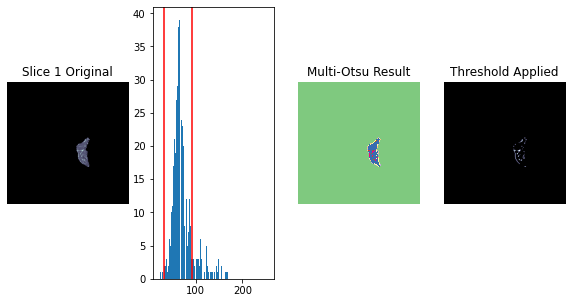

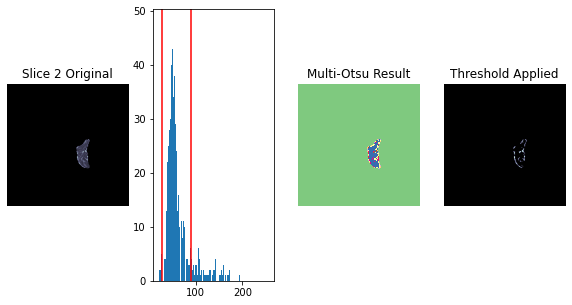

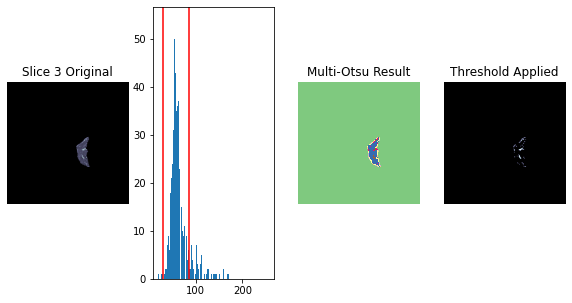

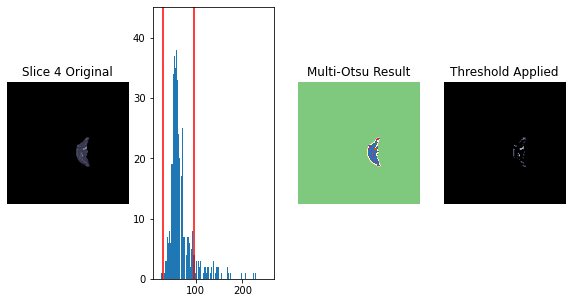

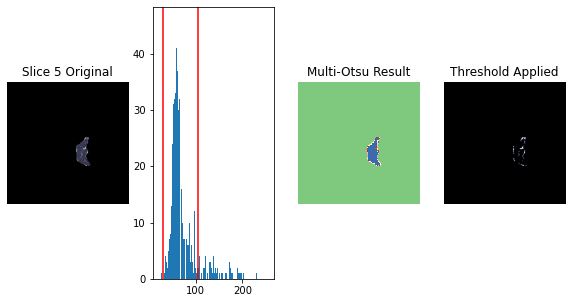

In [571]:
iThreshold_bf=[]
for i in range(j):
    iThreshold_bf.append([])
    iThreshold_bf[i]=multi_otsu(ROIbf[i])

In [573]:
def ITSA_bf(i, roivar, ots, zcheck):
    k_bf=1
    ThPrev_bf=0 
    ThRev_bf= ots[i] 
    x_bf=0
    y_bf=0
    while ThRev_bf!=ThPrev_bf:
        ThPrev_bf=ThRev_bf
        prefatmask_bf = (ROIbf[i]>ThRev_bf)
        prefatmask_bf = np.uint8(prefatmask_bf)
        ret_bf, fatmask_bf = cv2.threshold(prefatmask_bf,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next_bf=zcheck[i+1]+fatmask_bf
            ret_bf, fatconnectedparts_next_bf= cv2.threshold(fatcombined_next_bf,1,1,cv2.THRESH_BINARY)
            z_connection_bf=fatconnectedparts_next_bf
        elif i==(j-1):
            fatcombined_prev_bf=zcheck[i-1]+fatmask_bf
            ret_bf, fatconnectedparts_prev_bf= cv2.threshold(fatcombined_prev_bf,1,1,cv2.THRESH_BINARY)
            z_connection_bf=fatconnectedparts_prev_bf
        else:
            fatcombined_prev_bf=zcheck[i-1]+fatmask_bf
            fatcombined_next_bf=fatmask_bf+zcheck[i+1]
            ret_bf, fatconnectedparts_prev_bf= cv2.threshold(fatcombined_prev_bf,1,1,cv2.THRESH_BINARY)
            ret_bf, fatconnectedparts_next_bf= cv2.threshold(fatcombined_next_bf,1,1,cv2.THRESH_BINARY)

            z_connection_bf=fatconnectedparts_prev_bf+fatconnectedparts_next_bf
            ret_bf, z_connection_bf= cv2.threshold(z_connection_bf,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates_bf= np.argwhere(z_connection_bf ==1) #put coordinates of Z-connections into a list      
        im_ff_bf=fatmask_bf.copy()
        h_bf, w_bf = im_ff_bf.shape[:2] #added
        mask_bf = np.zeros((h_bf+2, w_bf+2), np.uint8)
        for item in range(len(coordinates_bf)):
            cv2.floodFill(im_ff_bf, mask_bf, (coordinates_bf[item][1],coordinates_bf[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ_bf =label(im_ff_bf==1)
        nonZ_keep_bf = (morphology.remove_small_objects(nonZ_bf,min_size=8, connectivity=1))
        ret_bf, nonZ_keep_bf= cv2.threshold(np.uint8(nonZ_keep_bf),0,1,cv2.THRESH_BINARY)
        Z_bf = (im_ff_bf==2)
        prefatseg1_bf=(Z_bf+nonZ_keep_bf) #do we need int cus boolean??
        fatseg1_bf=prefatseg1_bf*ROIbf[i]
        #Fat and Muscle Quantification
        preMuscSegP_bf=ROIbf[i]-fatseg1_bf
        MuscSegP_bf=np.ma.masked_where(preMuscSegP_bf == 0, preMuscSegP_bf)
        FatSegP_bf=np.ma.masked_where(fatseg1_bf==0,fatseg1_bf) 
        MuscSegI_bf=np.mean(MuscSegP_bf)
        FatSegI_bf=np.mean(FatSegP_bf)
        ThRev_bf=(1+((FatSegI_bf-MuscSegI_bf)/FatSegI_bf))*MuscSegI_bf
        print (f"Slice #{i+1} Iteration={k_bf}\n\tThPrev={ThPrev_bf}\n\tThRev={ThRev_bf}\n")

        k_bf+=1
        if k_bf==50:
            break

    thresholds_bf=ThRev_bf
    return prefatseg1_bf, fatseg1_bf, thresholds_bf

In [574]:
#Th1 R2
fatseg1vol_mask_bf=np.zeros([bf.shape[0], bf.shape[1], bf.shape[2]], dtype='uint8')
fatseg1vol_bf=np.zeros([bf.shape[0], bf.shape[1], bf.shape[2]], dtype='uint8') #change name
threshold_R1_bf=[] #change name compared to single slice?
for i in range(j):
    threshold_R1_bf.append([])
    fatseg1vol_mask_bf[i],fatseg1vol_bf[i], threshold_R1_bf[i]=ITSA_bf(i, ROIbf,iThreshold_bf,bf)  #fatsegfinalvol_mask_R1=round 1 final fat mask with islands REMOVED
    print (f"Slice #{i+1} Th1 = {threshold_R1_bf[i]}")
    print ("-----------------------------------------------------------")

for i in range(j):
    print (f"Slice #{i+1} Th1 OG/Rev={threshold_R1_bf[i]}")

Slice #1 Iteration=1
	ThPrev=92.859375
	ThRev=94.44239216970182

Slice #1 Iteration=2
	ThPrev=94.44239216970182
	ThRev=95.26991728017352

Slice #1 Iteration=3
	ThPrev=95.26991728017352
	ThRev=95.59228604936743

Slice #1 Iteration=4
	ThPrev=95.59228604936743
	ThRev=95.59228604936743

Slice #1 Th1 = 95.59228604936743
-----------------------------------------------------------
Slice #2 Iteration=1
	ThPrev=89.80078125
	ThRev=84.86371921067686

Slice #2 Iteration=2
	ThPrev=84.86371921067686
	ThRev=82.84289677783805

Slice #2 Iteration=3
	ThPrev=82.84289677783805
	ThRev=82.4485981667058

Slice #2 Iteration=4
	ThPrev=82.4485981667058
	ThRev=82.4485981667058

Slice #2 Th1 = 82.4485981667058
-----------------------------------------------------------
Slice #3 Iteration=1
	ThPrev=85.890625
	ThRev=86.45042354557192

Slice #3 Iteration=2
	ThPrev=86.45042354557192
	ThRev=86.84543439036791

Slice #3 Iteration=3
	ThPrev=86.84543439036791
	ThRev=86.84543439036791

Slice #3 Th1 = 86.84543439036791
----

<ipython-input-573-374159a56470>:37: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nonZ_keep_bf = (morphology.remove_small_objects(nonZ_bf,min_size=8, connectivity=1))


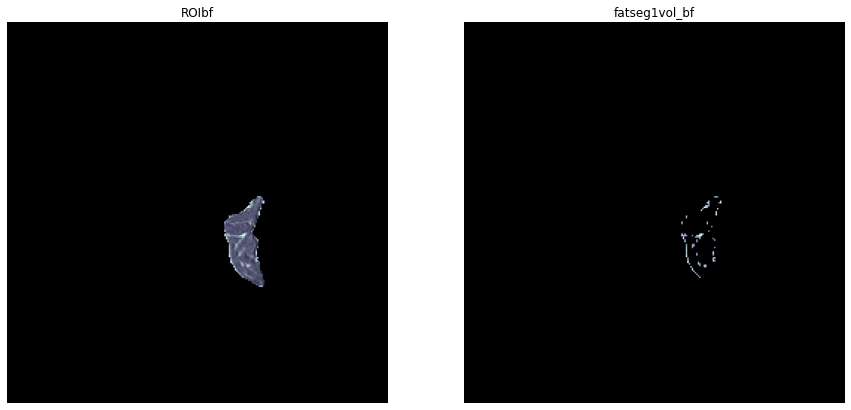

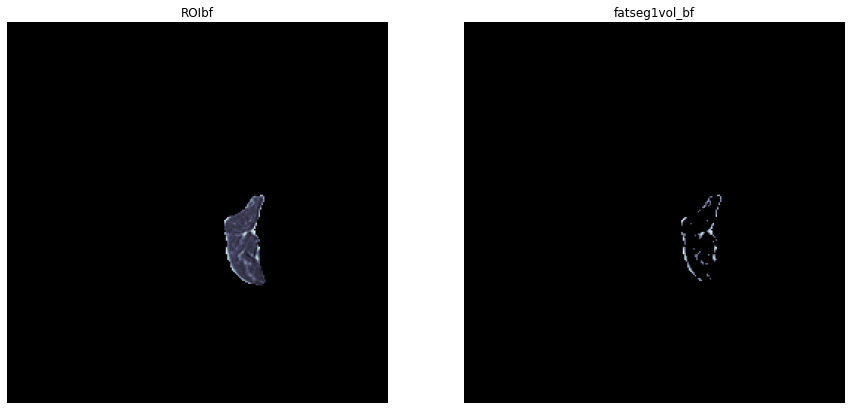

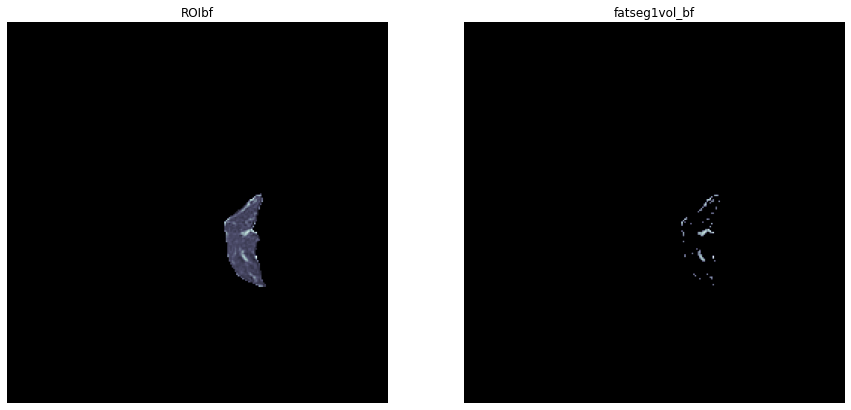

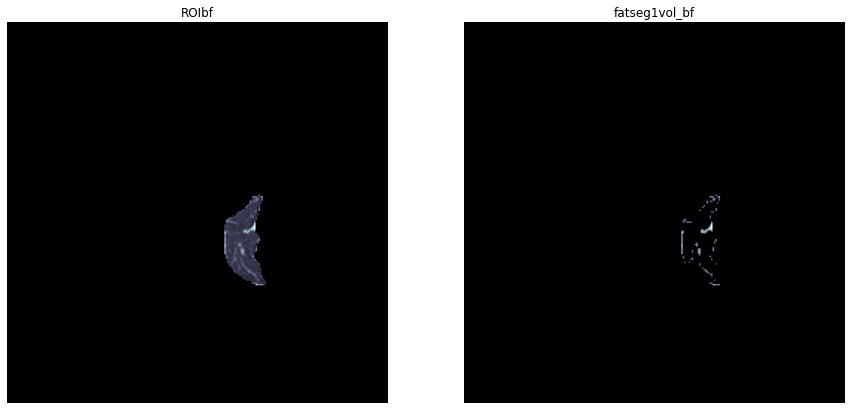

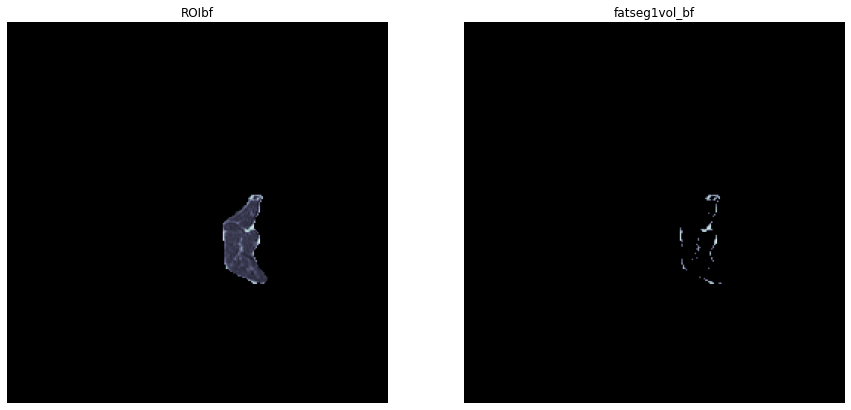

In [578]:
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIbf[i],"bone")
    axs[0].set_title(f"ROIbf")
    axs[0].axis("off")
    axs[1].imshow(fatseg1vol_bf[i],"bone")
    axs[1].set_title(f"fatseg1vol_bf")
    axs[1].axis("off")

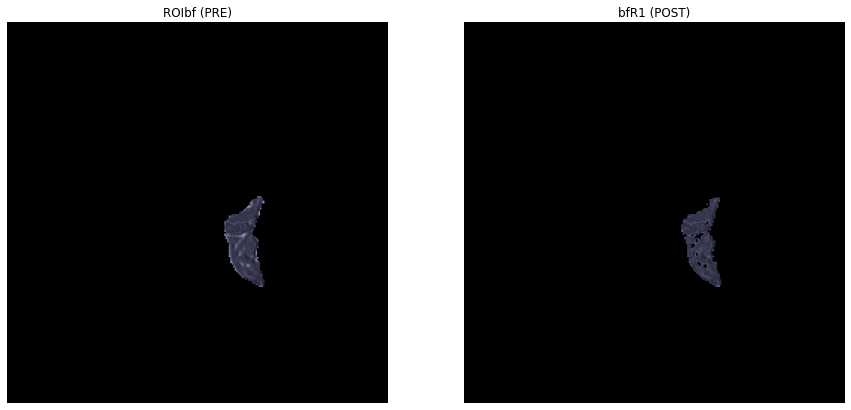

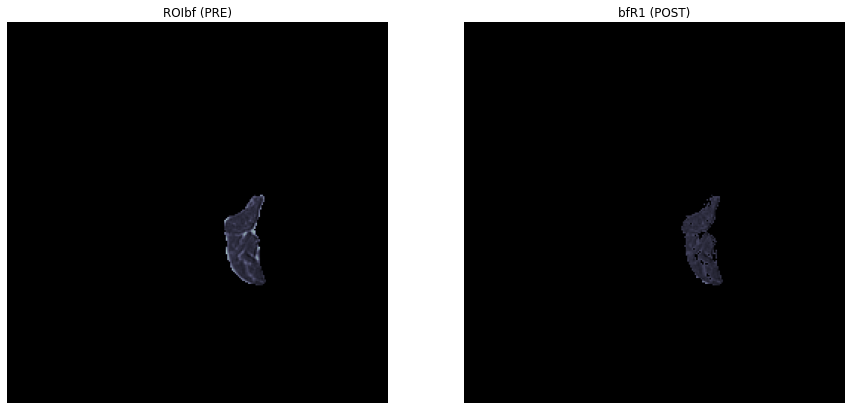

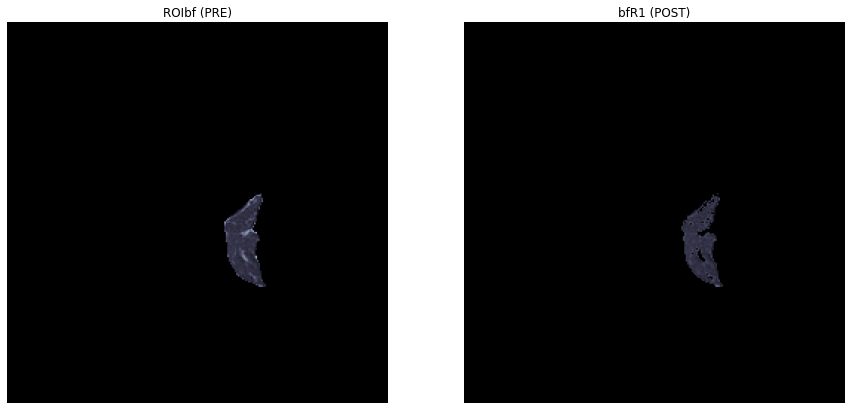

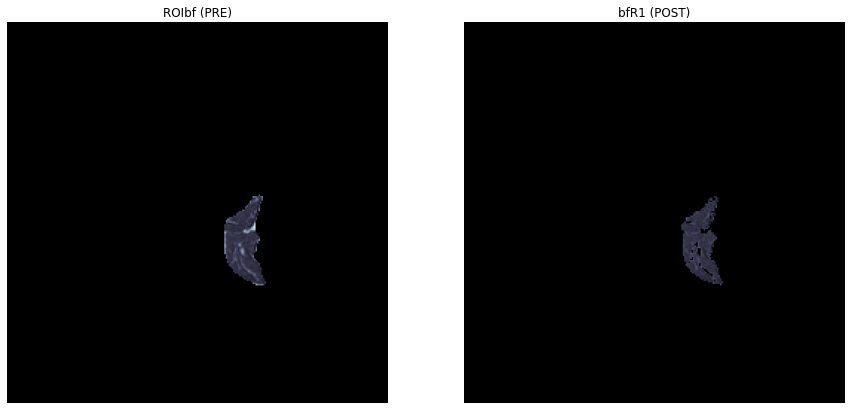

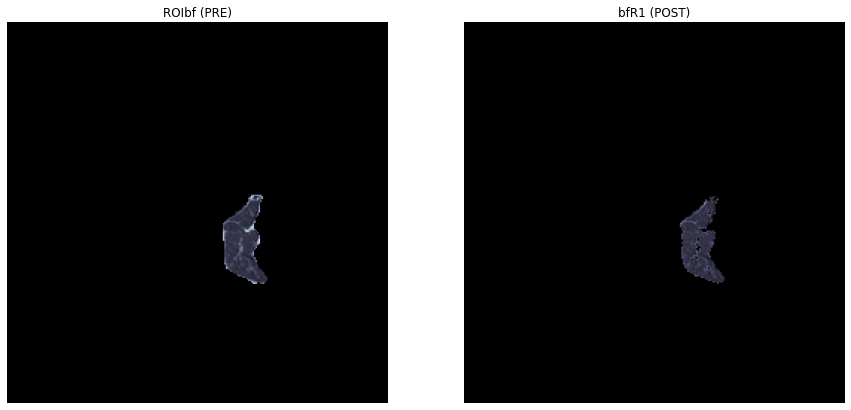

In [582]:
#Remove the first round of fat
bfR1=ROIbf-fatseg1vol_bf
for i in range (j):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIbf[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"ROIbf (PRE)")
    axs[0].axis("off")
    axs[1].imshow(bfR1[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"bfR1 (POST)")
    axs[1].axis("off")

# # ITSA Implementation (ST)

In [536]:
st=outputs[: , :, :, 7]
ROIst=st*inputs1

[26.23242188 67.82617188]
Slice 1 otsu threshold=67.826171875
[20.24609375 54.08203125]
Slice 2 otsu threshold=54.08203125
[25.734375 83.953125]
Slice 3 otsu threshold=83.953125
[26.8046875 79.6796875]
Slice 4 otsu threshold=79.6796875
[28.81835938 92.66210938]
Slice 5 otsu threshold=92.662109375


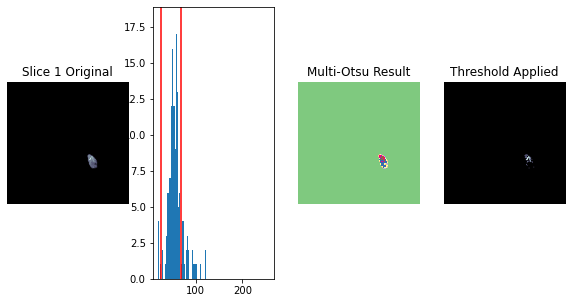

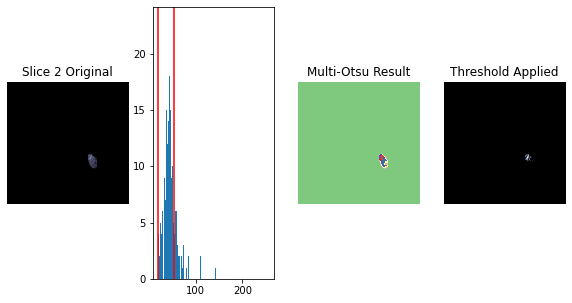

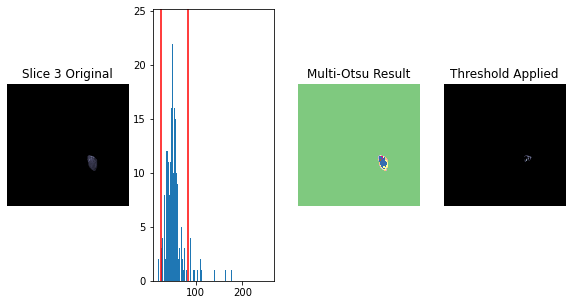

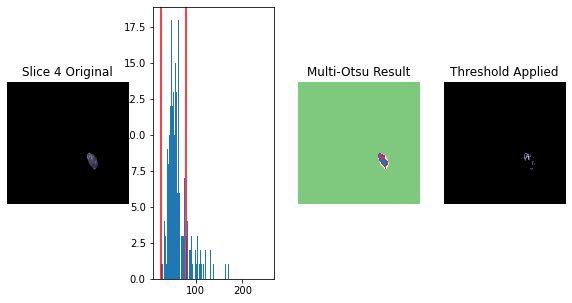

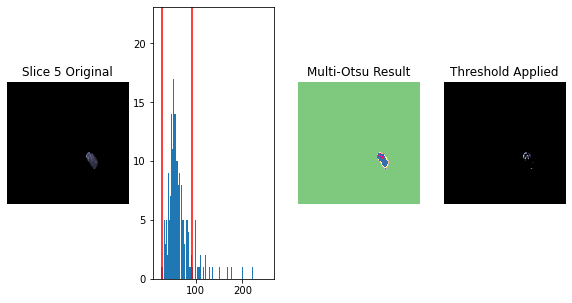

In [543]:
iThreshold_st=[]
for i in range(j):
    iThreshold_st.append([])
    iThreshold_st[i]=multi_otsu(ROIst[i])

# # ITSA Implementation (SM)

In [537]:
sm=outputs[: , :, :, 8]
ROIsm=sm*inputs1

[28.91992188 81.58007812]
Slice 1 otsu threshold=81.580078125
[20.73046875 60.83203125]
Slice 2 otsu threshold=60.83203125
[23.62304688 71.66992188]
Slice 3 otsu threshold=71.669921875
[29.0390625 83.1796875]
Slice 4 otsu threshold=83.1796875
[29.58007812 83.27929688]
Slice 5 otsu threshold=83.279296875


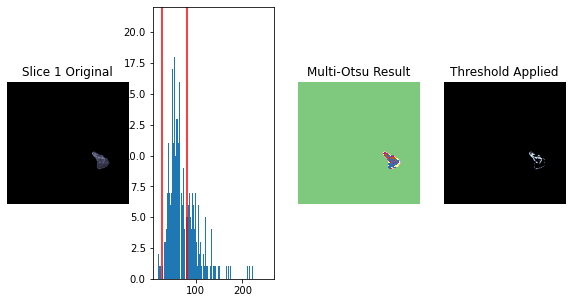

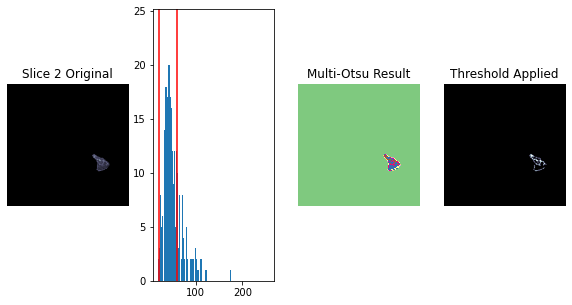

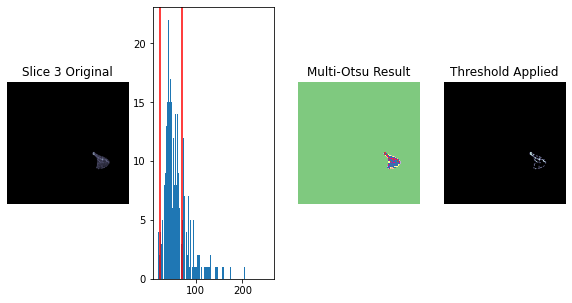

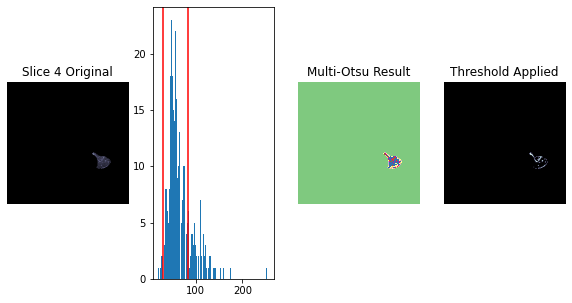

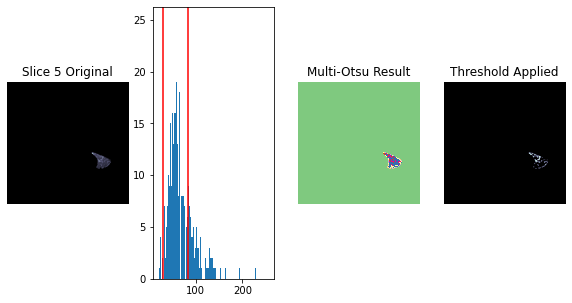

In [544]:
iThreshold_sm=[]
for i in range(j):
    iThreshold_sm.append([])
    iThreshold_sm[i]=multi_otsu(ROIsm[i])

In [557]:
def ITSA_sm(i, roivar, ots, zcheck):
    k_sm=1
    ThPrev_sm=0 
    ThRev_sm= ots[i] 
    x_sm=0
    y_sm=0
    while ThRev_sm!=ThPrev_sm:
        ThPrev_sm=ThRev_sm
        prefatmask_sm = (ROIsm[i]>ThRev_sm)
        prefatmask_sm = np.uint8(prefatmask_sm)
        ret_sm, fatmask_sm = cv2.threshold(prefatmask_sm,0,1,cv2.THRESH_BINARY)  #need this??
        if i==0:
            fatcombined_next_sm=zcheck[i+1]+fatmask_sm
            ret_sm, fatconnectedparts_next_sm= cv2.threshold(fatcombined_next_sm,1,1,cv2.THRESH_BINARY)
            z_connection_sm=fatconnectedparts_next_sm
        elif i==(j-1):
            fatcombined_prev_sm=zcheck[i-1]+fatmask_sm
            ret_sm, fatconnectedparts_prev_sm= cv2.threshold(fatcombined_prev_sm,1,1,cv2.THRESH_BINARY)
            z_connection_sm=fatconnectedparts_prev_sm
        else:
            fatcombined_prev_sm=zcheck[i-1]+fatmask_sm
            fatcombined_next_sm=fatmask_sm+zcheck[i+1]
            ret_sm, fatconnectedparts_prev_sm= cv2.threshold(fatcombined_prev_sm,1,1,cv2.THRESH_BINARY)
            ret_sm, fatconnectedparts_next_sm= cv2.threshold(fatcombined_next_sm,1,1,cv2.THRESH_BINARY)

            z_connection_sm=fatconnectedparts_prev_sm+fatconnectedparts_next_sm
            ret_sm, z_connection_sm= cv2.threshold(z_connection_sm,0,1,cv2.THRESH_BINARY)         
        #NEW: find XY connections to Z connected parts
        coordinates_sm= np.argwhere(z_connection_sm ==1) #put coordinates of Z-connections into a list      
        im_ff_sm=fatmask_sm.copy()
        h_sm, w_sm = im_ff_sm.shape[:2] #added
        mask_sm = np.zeros((h_sm+2, w_sm+2), np.uint8)
        for item in range(len(coordinates_sm)):
            cv2.floodFill(im_ff_sm, mask_sm, (coordinates_sm[item][1],coordinates_sm[item][0]), 2) 
        #Remove small islands for Non-Z parts
        nonZ_sm =label(im_ff_sm==1)
        nonZ_keep_sm = (morphology.remove_small_objects(nonZ_sm,min_size=8, connectivity=1))
        ret_sm, nonZ_keep_sm= cv2.threshold(np.uint8(nonZ_keep_sm),0,1,cv2.THRESH_BINARY)
        Z_sm = (im_ff_sm==2)
        prefatseg1_sm=(Z_sm+nonZ_keep_sm) #do we need int cus boolean??
        fatseg1_sm=prefatseg1_sm*ROIsm[i]
        #Fat and Muscle Quantification
        preMuscSegP_sm=ROIsm[i]-fatseg1_sm
        MuscSegP_sm=np.ma.masked_where(preMuscSegP_sm == 0, preMuscSegP_sm)
        FatSegP_sm=np.ma.masked_where(fatseg1_sm==0,fatseg1_sm) 
        MuscSegI_sm=np.mean(MuscSegP_sm)
        FatSegI_sm=np.mean(FatSegP_sm)
        ThRev_sm=(1+((FatSegI_sm-MuscSegI_sm)/FatSegI_sm))*MuscSegI_sm
        print (f"Slice #{i+1} Iteration={k_sm}\n\tThPrev={ThPrev_sm}\n\tThRev={ThRev_sm}\n")
        k_sm+=1
        if k_sm==50:
            break
    thresholds_sm=ThRev_sm
    return prefatseg1_sm, fatseg1_sm, thresholds_sm

In [656]:
fatseg1vol_mask_sm=np.zeros([sm.shape[0], sm.shape[1], sm.shape[2]], dtype='uint8')
fatseg1vol_sm=np.zeros([sm.shape[0], sm.shape[1], sm.shape[2]], dtype='uint8') 
threshold_R1_sm=[] 
for i in range(j):
    threshold_R1_sm.append([])
    fatseg1vol_mask_sm[i],fatseg1vol_sm[i], threshold_R1_sm[i]=ITSA_sm(i, ROIsm,iThreshold_sm,sm)  
    print (f"Slice #{i+1} Th1 = {threshold_R1_sm[i]}")
    print ("-----------------------------------------------------------")
for i in range(j):
    print (f"Slice #{i+1} Th1 OG/Rev={threshold_R1_sm[i]}")

Slice #1 Iteration=1
	ThPrev=81.580078125
	ThRev=82.71094743819542

Slice #1 Iteration=2
	ThPrev=82.71094743819542
	ThRev=83.23225124528764

Slice #1 Iteration=3
	ThPrev=83.23225124528764
	ThRev=83.85494862028774

Slice #1 Iteration=4
	ThPrev=83.85494862028774
	ThRev=83.85494862028774

Slice #1 Th1 = 83.85494862028774
-----------------------------------------------------------
Slice #2 Iteration=1
	ThPrev=60.83203125
	ThRev=60.70117230790876

Slice #2 Iteration=2
	ThPrev=60.70117230790876
	ThRev=60.70117230790876

Slice #2 Th1 = 60.70117230790876
-----------------------------------------------------------
Slice #3 Iteration=1
	ThPrev=71.669921875
	ThRev=70.42702133112857

Slice #3 Iteration=2
	ThPrev=70.42702133112857
	ThRev=69.60319093792619

Slice #3 Iteration=3
	ThPrev=69.60319093792619
	ThRev=69.42415999348826

Slice #3 Iteration=4
	ThPrev=69.42415999348826
	ThRev=69.42415999348826

Slice #3 Th1 = 69.42415999348826
-----------------------------------------------------------
Slice #

<ipython-input-557-b925e0a383c8>:37: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  nonZ_keep_sm = (morphology.remove_small_objects(nonZ_sm,min_size=8, connectivity=1))


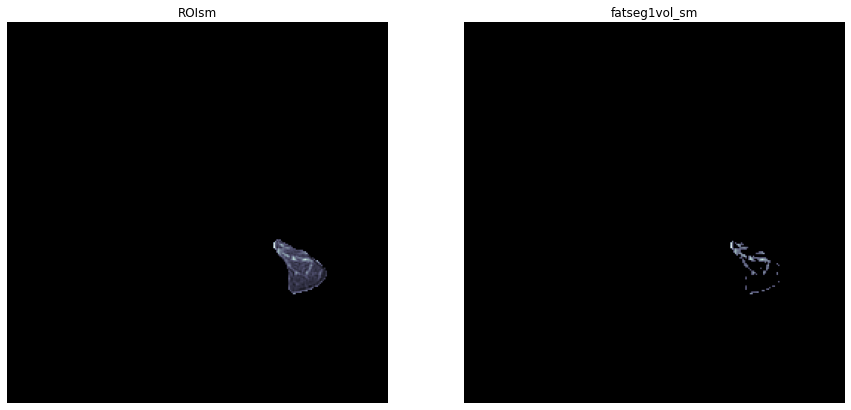

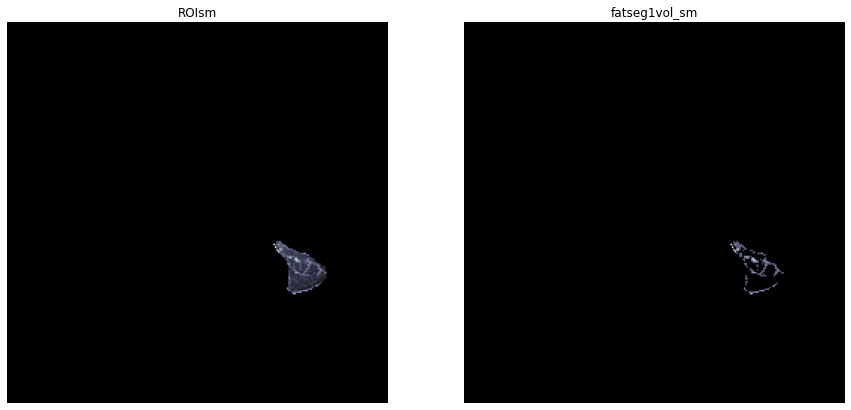

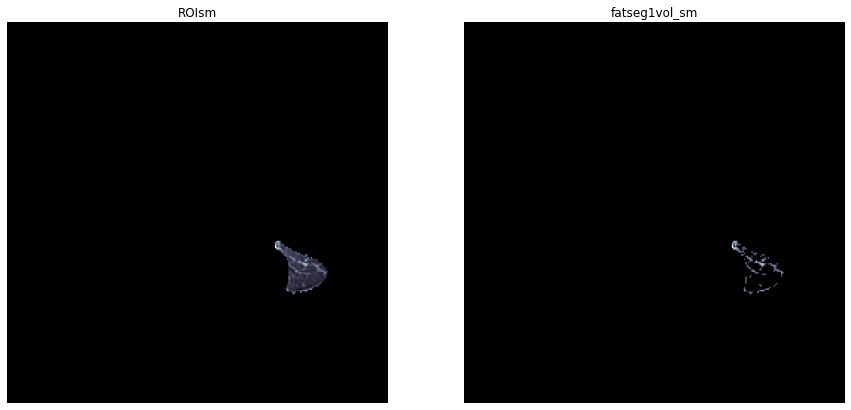

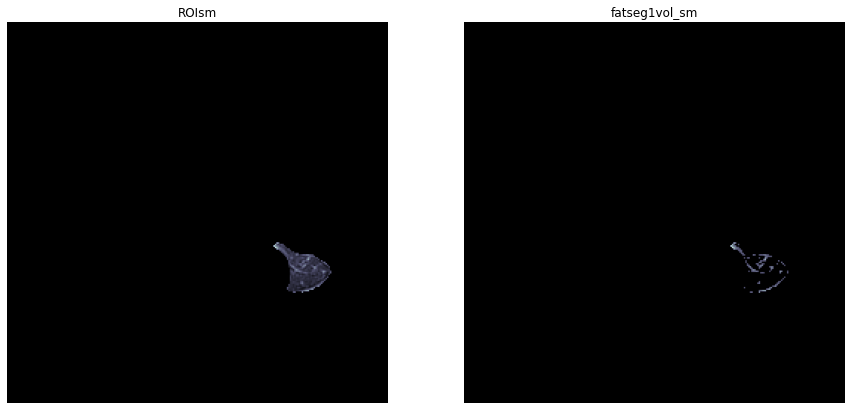

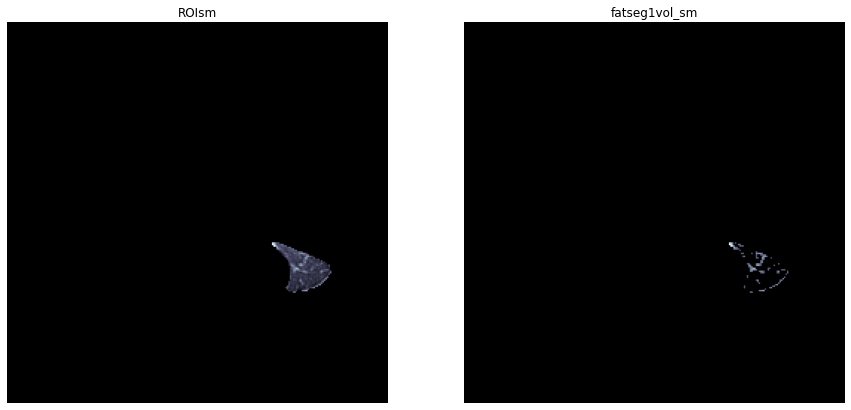

In [657]:
#Visualization of IntraMSK Fat segmentation from Thres. Optimization
for i in range (5):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIsm[i],"bone",)
    axs[0].set_title(f"ROIsm")
    axs[0].axis("off")
    axs[1].imshow(fatseg1vol_sm[i],"bone")
    axs[1].set_title(f"fatseg1vol_sm")
    axs[1].axis("off")

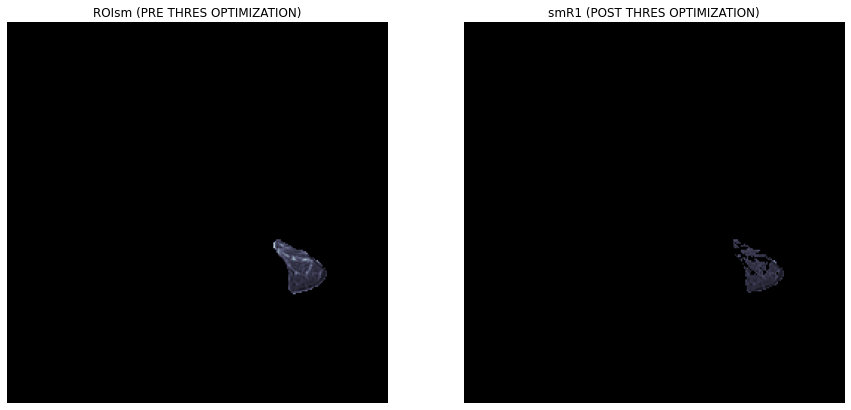

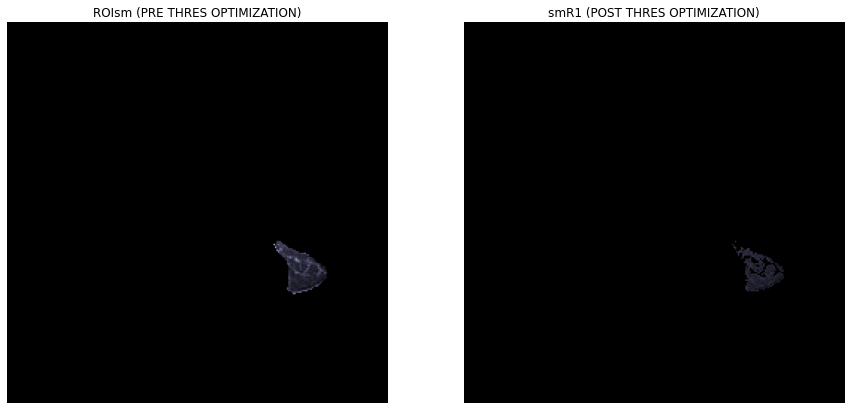

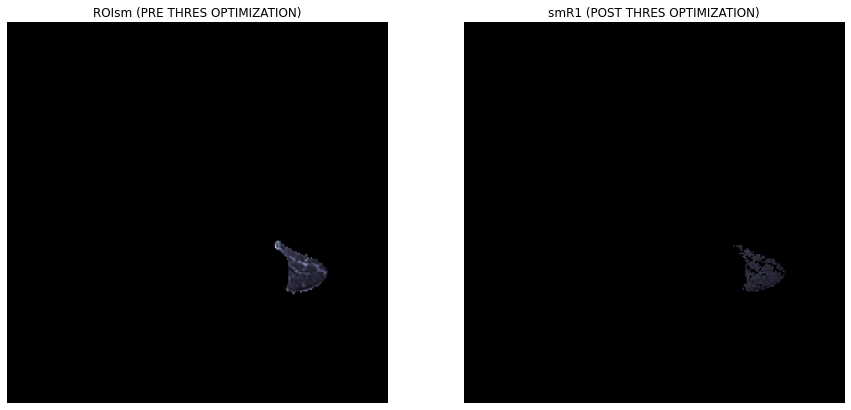

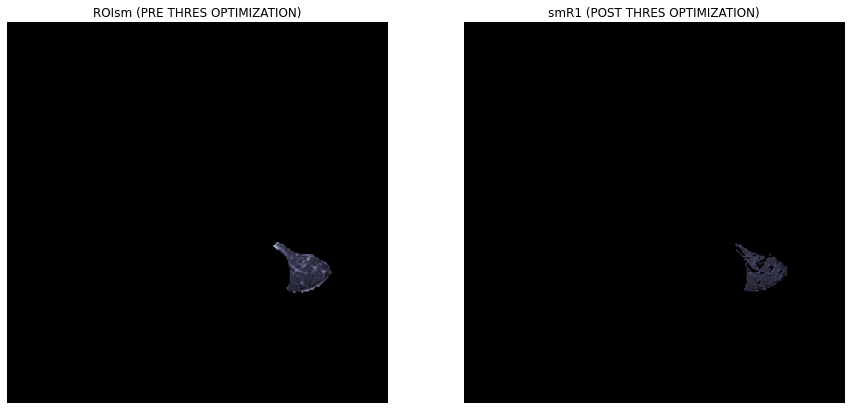

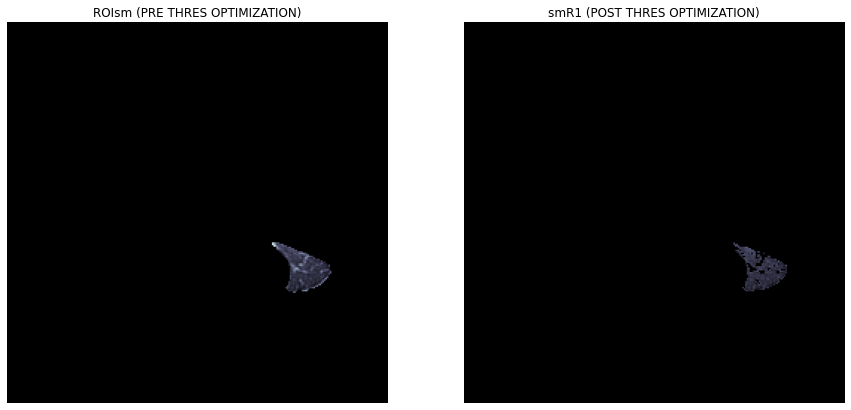

In [658]:
#Semimembranosus without Intramuscular Fat (Round 1 of Thres. Optimization)
smR1=ROIsm-fatseg1vol_sm

for i in range (5):
    fig, axs=plt.subplots (1,2, figsize=(15,10))
    axs[0].imshow(ROIsm[i],"bone",vmin=0,vmax=255)
    axs[0].set_title(f"ROIsm (PRE THRES OPTIMIZATION)")
    axs[0].axis("off")
    axs[1].imshow(smR1[i],"bone",vmin=0,vmax=255)
    axs[1].set_title(f"smR1 (POST THRES OPTIMIZATION)")
    axs[1].axis("off")